
# ALAD - Toy examples¶

This is the notebook that generated Figure 2 in "Adversarially learnt anomaly detection" Credits : https://github.com/ChunyuanLI/ALICE

## Imports


In [1]:
%matplotlib inline

import os
import pdb


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import torch as torch
import torch.nn as nn

from utils.data_gmm import GMM_distribution, sample_GMM, plot_GMM
from utils.data_utils import shuffle, iter_data, ToyDataset
from tqdm import tqdm
import sklearn.datasets

In [3]:

""" parameters """

DATASET = '4gaussians' # 5gaussians, swiss_roll, s_curve
N_NOISY = 100


device = 'cuda'

n_epoch = 600
batch_size  = 1024
dataset_size_x = 512*4
dataset_size_z = 512*4

dataset_size_x_test = 512*2
dataset_size_z_test = 512*2

input_dim = 2
latent_dim = 2
eps_dim = 2

n_layer_disc  = 2
n_hidden_disc = 256
n_layer_gen   = 3
n_hidden_gen  = 256
n_layer_inf   = 2
n_hidden_inf  = 256

In [4]:
""" Create directory for results """
result_dir = 'results/alad_toy/'
directory = result_dir
if not os.path.exists(directory):
    os.makedirs(directory)

## Training dataset

#### 4 or 5 GMM

In [5]:
""" Create dataset """

def four_five_gaussians(p1=0):
    # create X dataset
    global dataset_size_x
    means_x = map(lambda x:  np.array(x), [[2, 2],
                                          [-2, -2],
                                          [2, -2],
                                          [-2, 2],
                                           [0, 0]])
    
    means_x = list(means_x)
    std_x = 0.02
    variances_x = [np.eye(2) * std_x for _ in means_x]

    #contamination = 4.0*p/(1-p)
    priors_x = np.array([1.0, 1.0, 1.0, 1.0, p1])
    priors_x /= sum(priors_x)
    #print(priors_x)
    gaussian_mixture = GMM_distribution(means=means_x,
                                                   variances=variances_x,
                                                   priors=priors_x)
    dataset_x = sample_GMM(dataset_size_x, means_x, variances_x, priors_x, sources=('features', ))
    return dataset_x





You can control the level of the fifth gaussian in the training set with the $p$ parameter

Generate training dataset


In [6]:
dataset_x = four_five_gaussians(p1=0.0)
save_path_x = result_dir + 'X_4gmm_data_train.png'

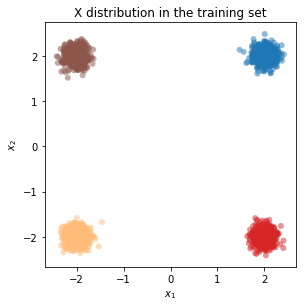

In [7]:
## input x
X_dataset  = dataset_x.data['samples']
X_targets = dataset_x.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_dataset[:, 0], X_dataset[:, 1], c=cm.tab20(X_targets.astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.set_title("X distribution in the training set" )
ax.axis('on')
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()


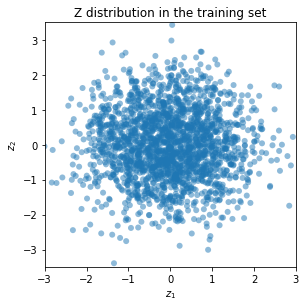

In [8]:


# create Z dataset
means_z = map(lambda x:  np.array(x), [[0, 0]])
means_z = list(means_z)
std_z = 1.0
variances_z = [np.eye(2) * std_z for _ in means_z]
priors_z = [1.0/len(means_z) for _ in means_z]

dataset_z = sample_GMM(dataset_size_z, means_z, variances_z, priors_z, sources=('features', ))
save_path_z = result_dir + 'Z_gmm_data_train.png'

##  input z
Z_dataset = dataset_z.data['samples']
Z_labels  = dataset_z.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_dataset[:, 0], Z_dataset[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.set_title("Z distribution in the training set")
ax.axis('on')
plt.savefig(save_path_z, transparent=True, bbox_inches='tight')
plt.show()



## Networks

In [9]:
""" Networks """

# Models constructors takes tensor arguments only to get input shapes for networks


class Generative_Network(nn.Module):
    def __init__(self,x, input_dim,n_layer, n_hidden, eps_dim, reuse = False):
        super(Generative_Network, self).__init__()
        layers = []
        self.z = z.to(device)
        z_shape = list(z.shape)[1]
            
        layers.append(nn.Linear(z_shape, n_hidden).to(device))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layer-1):
            layers.append(nn.Linear(n_hidden,n_hidden).to(device))
            layers.append(nn.ReLU().to(device))
            
        layers.append(nn.Linear(n_hidden,input_dim).to(device))
        self.gn = nn.Sequential(*layers)
           
            
    def forward(self,z):
        return self.gn(z.to(device))


class Inference_Network(nn.Module):
    def __init__(self, x, latent_dim,n_layer, n_hidden, eps_dim, reuse = False):
        super(Inference_Network, self).__init__()
        self.x = x.to(device)
        layers = []
        x_shape = list(x.shape)[1]
        layers.append(nn.Linear(input_dim, n_hidden).to(device))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layer-1):
            layers.append(nn.Linear(n_hidden,n_hidden).to(device))
            layers.append(nn.ReLU().to(device))
            
        layers.append(nn.Linear(n_hidden,latent_dim).to(device))
        self.infn = nn.Sequential(*layers)
            
    def forward(self,x):
        return self.infn(x.to(device))

    
class Data_Network_xz(nn.Module,):
    def __init__(self,x, z, n_layers=2, n_hidden=128, activation_fn=None,reuse=False):
        super(Data_Network_xz, self).__init__()
        layers = []
        
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.activation_fn = activation_fn
        self.reuse = reuse
        self.x = x.to(device)
        self.z = z.to(device)
        self.h = torch.cat((x, z), 1).to(device)
        
        h_shape = list(self.h.shape)[1]
        
        layers.append(nn.Linear(h_shape, n_hidden).to(device))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layers-1):
            layers.append(nn.Linear(n_hidden,n_hidden).to(device))
            layers.append(nn.ReLU().to(device))
            
        layers.append(nn.Linear(n_hidden,1).to(device))
        
        if activation_fn:
            layers.append(activation_fn.to(device))
            
        self.dn_xz = nn.Sequential(*layers)
         
        
    def forward(self,x,z):
        h = torch.cat((x.to(device),z.to(device)), 1)
        res = self.dn_xz(h)
        return res
    
    
class Data_Network_xx(nn.Module):
    def __init__(self,x, x_hat, n_layers=1, n_hidden=128, activation_fn=None,reuse=False):
        super(Data_Network_xx, self).__init__()
        layers = []
        self.h = torch.cat( (x, x_hat), 1).to(device)
        h_shape = list(self.h.shape)[1]
        
        layers.append(nn.Linear(h_shape, n_hidden).to(device))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layers-1):
            layers.append(nn.Linear(n_hidden,n_hidden).to(device))
            layers.append(nn.ReLU().to(device))
            
        layers.append(nn.Linear(n_hidden,1).to(device))
        if activation_fn:
            layers.append(activation_fn.to(device))
        self.dn_xx = nn.Sequential(*layers)
        
    def forward(self,x,x_hat):
        h = torch.cat( (x.to(device), x_hat.to(device)), 1)
        res = self.dn_xx(h)
        return res
    
    
class Data_Network_zz(nn.Module):
    def __init__(self,z, z_prime, n_layers=1, n_hidden=128, activation_fn=None,reuse=False):
        super(Data_Network_zz, self).__init__()
        layers = []
        self.h = torch.cat( (z, z_prime), 1).to(device)
        h_shape = list(self.h.shape)[1]
        
        layers.append(nn.Linear(h_shape, n_hidden).to(device))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layers-1):
            layers.append(nn.Linear(n_hidden,n_hidden).to(device))
            layers.append(nn.ReLU().to(device))
            
        layers.append(nn.Linear(n_hidden,1).to(device))
        if activation_fn:
            layers.append(activation_fn.to(device))
        self.dn_zz = nn.Sequential(*layers)
        
    def forward(self, z, z_prime):
        h = torch.cat( (z.to(device), z_prime.to(device)), 1)
        res = self.dn_zz(h)
        return res

In [10]:


x = torch.ones([batch_size, input_dim],dtype = torch.float)
z = torch.ones([batch_size, latent_dim],dtype = torch.float)   
# decoder and encoder
gen = Generative_Network(z, input_dim , n_layer_gen, n_hidden_gen, eps_dim)
inf = Inference_Network(x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim)
dn_xz = Data_Network_xz(x, z, n_layers=n_layer_disc, n_hidden=n_hidden_disc)
dn_zz = Data_Network_zz(z,z)
dn_xx = Data_Network_xx(x,x)



/home/austrotaxus/anaconda3/envs/marsanomalies/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 GeForce GTX 660 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


### Optimizers section:

In [11]:
# Train disc op does not contain dvars_zz?

disc_params = list(dn_zz.parameters())+list(dn_xz.parameters())+list(dn_xx.parameters())
disc_optimizer = torch.optim.Adam( disc_params, lr=1e-3,betas = (0.5,0.999))

gen_params = list(gen.parameters()) + list(inf.parameters())
gen_optimizer = torch.optim.Adam(gen_params , lr = 1e-3, betas = (0.5,0.999))


### Learning procedure 

In [12]:
FG = []
FD = []

for epoch in tqdm( range(n_epoch), total=n_epoch):
    X_dataset= shuffle(X_dataset)
    Z_dataset= shuffle(Z_dataset)
    
    bce = nn.BCELoss()
    sigmoid = nn.Sigmoid()

    i = 0
    f_g= [None]*4
    f_d = None
    
    for xmb, zmb in iter_data(X_dataset, Z_dataset, size=batch_size):    
        x = torch.Tensor(xmb)
        z = torch.Tensor(zmb)
        i = i+1
        
        p_x = gen(z)
        q_z = inf(x)
        
        decoder_logit = dn_xz(p_x, z)
        encoder_logit = dn_xz(x , q_z)
    
        decoder_loss = bce(sigmoid(decoder_logit),torch.zeros_like(decoder_logit))
        encoder_loss = bce(sigmoid(encoder_logit),torch.ones_like(encoder_logit))
        
        dis_loss_xz =torch.mean(encoder_loss+decoder_loss)

        decoder_loss2 = bce(sigmoid(decoder_logit),torch.ones_like(decoder_logit))
        encoder_loss2 = bce(sigmoid(encoder_logit),torch.zeros_like(encoder_logit))

        gen_loss_xz = torch.mean((decoder_loss2))  + (torch.mean(encoder_loss2))
        
        rec_z = inf(p_x)
        rec_x = gen(q_z)
        
        x_logit_real = dn_xx(x,x)
        x_logit_fake = dn_xx(x,rec_x)
        z_logit_real = dn_zz(z,z)
        z_logit_fake = dn_zz(z,rec_z)

        x_sigmoid_real = bce(sigmoid(x_logit_real),torch.ones_like(x_logit_real))
        x_sigmoid_fake = bce(sigmoid(x_logit_fake),torch.zeros_like(x_logit_fake))

        x_sigmoid_real2 = bce(sigmoid(x_logit_real),torch.zeros_like(x_logit_real))
        x_sigmoid_fake2 = bce(sigmoid(x_logit_fake),torch.ones_like(x_logit_fake))

        z_sigmoid_real = bce(sigmoid(z_logit_real),torch.ones_like(z_logit_real))
        z_sigmoid_fake = bce(sigmoid(z_logit_fake),torch.zeros_like(z_logit_fake))

        z_sigmoid_real2 = bce(sigmoid(z_logit_real),torch.zeros_like(z_logit_real))
        z_sigmoid_fake2 = bce(sigmoid(z_logit_fake),torch.ones_like(z_logit_fake))
        
        dis_loss_x = torch.mean(x_sigmoid_real + x_sigmoid_fake)
        dis_loss_z = torch.mean(z_sigmoid_real + z_sigmoid_fake)
        disc_loss = dis_loss_xz + dis_loss_x + dis_loss_z

        cost_x = torch.mean(x_sigmoid_real2 + x_sigmoid_fake2) 
        cost_z = torch.mean(z_sigmoid_real2 + z_sigmoid_fake2)
        gen_loss = gen_loss_xz + cost_x + cost_z
    
        for _ in range(1):
            disc_optimizer.zero_grad()
            disc_loss.backward(retain_graph = True)
            disc_optimizer.step()
            f_d = disc_loss.data
            
        # In the original article cycle below repeated 5 times, however for 
        # some reasone in my case it leads to insufficient regularization.
       
        
        for _ in range(1):
            gen_optimizer.zero_grad()
            gen_loss.backward(retain_graph = True)
            gen_optimizer.step()
            f_g = [gen_loss.data, gen_loss_xz.data, cost_x.data ,cost_z.data]
            
        FG.append(f_g)
        FD.append(f_d)
    
    print("epoch %d iter %d: discloss %f genloss %f adv_x %f recons_x %f " % (epoch, i, f_d, f_g[0], f_g[1], f_g[2]))



  0%|          | 3/600 [00:00<01:15,  7.86it/s]

epoch 0 iter 2: discloss 4.222807 genloss 4.243420 adv_x 1.475592 recons_x 1.338937 
epoch 1 iter 2: discloss 4.093225 genloss 4.447016 adv_x 1.713350 recons_x 1.305855 
epoch 2 iter 2: discloss 3.982695 genloss 4.707598 adv_x 2.032366 recons_x 1.221332 
epoch 3 iter 2: discloss 3.757632 genloss 5.045427 adv_x 2.294157 recons_x 1.295625 
epoch 4 iter 2: discloss 3.878856 genloss 5.016970 adv_x 2.190475 recons_x 1.401880 


  2%|▏         | 9/600 [00:00<00:51, 11.54it/s]

epoch 5 iter 2: discloss 3.847733 genloss 5.333400 adv_x 2.500945 recons_x 1.425294 
epoch 6 iter 2: discloss 3.815552 genloss 5.599094 adv_x 2.719441 recons_x 1.446687 
epoch 7 iter 2: discloss 3.801423 genloss 5.185589 adv_x 2.218982 recons_x 1.498390 
epoch 8 iter 2: discloss 3.551394 genloss 5.174950 adv_x 2.099638 recons_x 1.591798 
epoch 9 iter 2: discloss 3.498003 genloss 5.551251 adv_x 2.340513 recons_x 1.662034 


  2%|▎         | 15/600 [00:00<00:39, 14.96it/s]

epoch 10 iter 2: discloss 3.352201 genloss 5.635303 adv_x 2.329966 recons_x 1.691328 
epoch 11 iter 2: discloss 3.339499 genloss 5.712416 adv_x 2.488550 recons_x 1.700944 
epoch 12 iter 2: discloss 3.447969 genloss 6.050229 adv_x 2.979218 recons_x 1.666105 
epoch 13 iter 2: discloss 3.611180 genloss 6.344083 adv_x 3.329912 recons_x 1.617474 
epoch 14 iter 2: discloss 3.670205 genloss 6.233258 adv_x 3.211287 recons_x 1.581004 


  3%|▎         | 18/600 [00:00<00:35, 16.33it/s]

epoch 15 iter 2: discloss 3.780329 genloss 5.806944 adv_x 2.764487 recons_x 1.528615 
epoch 16 iter 2: discloss 4.253571 genloss 4.983374 adv_x 1.978293 recons_x 1.360577 
epoch 17 iter 2: discloss 3.958715 genloss 5.287203 adv_x 2.126596 recons_x 1.230630 
epoch 18 iter 2: discloss 3.236010 genloss 6.231851 adv_x 3.009028 recons_x 1.354974 
epoch 19 iter 2: discloss 3.190789 genloss 6.333194 adv_x 3.101292 recons_x 1.551546 


  4%|▍         | 24/600 [00:01<00:30, 18.94it/s]

epoch 20 iter 2: discloss 3.654296 genloss 6.105337 adv_x 3.001722 recons_x 1.650557 
epoch 21 iter 2: discloss 3.876706 genloss 6.328035 adv_x 3.276912 recons_x 1.774991 
epoch 22 iter 2: discloss 3.354649 genloss 7.483602 adv_x 4.174591 recons_x 1.950291 
epoch 23 iter 2: discloss 3.044746 genloss 7.853121 adv_x 4.394774 recons_x 1.863262 
epoch 24 iter 2: discloss 3.077531 genloss 7.520235 adv_x 4.067591 recons_x 1.777216 


  5%|▌         | 30/600 [00:01<00:28, 19.76it/s]

epoch 25 iter 2: discloss 3.481944 genloss 6.696486 adv_x 3.285418 recons_x 1.711236 
epoch 26 iter 2: discloss 3.893210 genloss 5.885223 adv_x 2.490097 recons_x 1.667375 
epoch 27 iter 2: discloss 3.918764 genloss 5.297525 adv_x 1.944275 recons_x 1.613055 
epoch 28 iter 2: discloss 4.040491 genloss 5.092765 adv_x 1.849006 recons_x 1.564265 
epoch 29 iter 2: discloss 4.315054 genloss 4.776276 adv_x 1.901637 recons_x 1.494835 


  6%|▌         | 33/600 [00:01<00:28, 20.20it/s]

epoch 30 iter 2: discloss 4.469593 genloss 5.270741 adv_x 2.413680 recons_x 1.717326 
epoch 31 iter 2: discloss 3.478406 genloss 6.623975 adv_x 3.153112 recons_x 2.149035 
epoch 32 iter 2: discloss 3.106153 genloss 6.935876 adv_x 3.271724 recons_x 2.042205 
epoch 33 iter 2: discloss 3.261104 genloss 6.856554 adv_x 3.217709 recons_x 1.963628 
epoch 34 iter 2: discloss 3.622925 genloss 6.407777 adv_x 2.823139 recons_x 1.912917 


  6%|▋         | 39/600 [00:01<00:27, 20.55it/s]

epoch 35 iter 2: discloss 3.934958 genloss 6.098889 adv_x 2.526641 recons_x 1.855703 
epoch 36 iter 2: discloss 4.257477 genloss 5.905464 adv_x 2.284818 recons_x 1.839017 
epoch 37 iter 2: discloss 4.219390 genloss 5.547413 adv_x 1.923198 recons_x 1.831902 
epoch 38 iter 2: discloss 3.813011 genloss 5.243651 adv_x 1.668693 recons_x 1.842512 
epoch 39 iter 2: discloss 3.555790 genloss 5.348551 adv_x 1.824008 recons_x 1.875620 


  8%|▊         | 45/600 [00:02<00:26, 20.96it/s]

epoch 40 iter 2: discloss 3.461689 genloss 5.510271 adv_x 1.991790 recons_x 1.865532 
epoch 41 iter 2: discloss 3.335872 genloss 5.724268 adv_x 2.169611 recons_x 1.862123 
epoch 42 iter 2: discloss 3.347302 genloss 5.761334 adv_x 2.222154 recons_x 1.842201 
epoch 43 iter 2: discloss 3.420334 genloss 5.698451 adv_x 2.168123 recons_x 1.863091 
epoch 44 iter 2: discloss 3.452766 genloss 5.697308 adv_x 2.144282 recons_x 1.905467 


  8%|▊         | 48/600 [00:02<00:26, 20.82it/s]

epoch 45 iter 2: discloss 3.255126 genloss 6.012351 adv_x 2.388443 recons_x 1.984850 
epoch 46 iter 2: discloss 3.262012 genloss 6.080494 adv_x 2.451941 recons_x 2.004068 
epoch 47 iter 2: discloss 3.540958 genloss 5.813845 adv_x 2.142877 recons_x 1.991046 
epoch 48 iter 2: discloss 3.650179 genloss 5.710197 adv_x 1.989963 recons_x 2.013742 
epoch 49 iter 2: discloss 3.619877 genloss 5.692605 adv_x 1.937951 recons_x 2.059883 


  9%|▉         | 54/600 [00:02<00:25, 21.17it/s]

epoch 50 iter 2: discloss 3.564041 genloss 5.677323 adv_x 1.935470 recons_x 2.083251 
epoch 51 iter 2: discloss 3.476841 genloss 5.682119 adv_x 1.934554 recons_x 2.091622 
epoch 52 iter 2: discloss 3.562039 genloss 5.543736 adv_x 1.793138 recons_x 2.057711 
epoch 53 iter 2: discloss 3.586281 genloss 5.590227 adv_x 1.749430 recons_x 2.093469 
epoch 54 iter 2: discloss 3.499787 genloss 5.698355 adv_x 1.781399 recons_x 2.179280 


 10%|█         | 60/600 [00:02<00:25, 21.28it/s]

epoch 55 iter 2: discloss 3.532355 genloss 5.660369 adv_x 1.732330 recons_x 2.186864 
epoch 56 iter 2: discloss 3.501410 genloss 5.637448 adv_x 1.780116 recons_x 2.119245 
epoch 57 iter 2: discloss 3.286881 genloss 5.792055 adv_x 1.964238 recons_x 2.149754 
epoch 58 iter 2: discloss 3.239109 genloss 5.826940 adv_x 2.099509 recons_x 2.115938 
epoch 59 iter 2: discloss 3.413628 genloss 5.675006 adv_x 2.006975 recons_x 2.071491 


 10%|█         | 63/600 [00:03<00:24, 21.55it/s]

epoch 60 iter 2: discloss 3.650337 genloss 5.494147 adv_x 1.835343 recons_x 2.078594 
epoch 61 iter 2: discloss 3.531410 genloss 5.693184 adv_x 1.818620 recons_x 2.204598 
epoch 62 iter 2: discloss 3.193105 genloss 6.151207 adv_x 1.974519 recons_x 2.408305 
epoch 63 iter 2: discloss 3.154085 genloss 6.145662 adv_x 1.898749 recons_x 2.480733 
epoch 64 iter 2: discloss 3.296285 genloss 6.112923 adv_x 1.802682 recons_x 2.522696 


 12%|█▏        | 69/600 [00:03<00:24, 21.24it/s]

epoch 65 iter 2: discloss 3.260563 genloss 6.157548 adv_x 1.927177 recons_x 2.446483 
epoch 66 iter 2: discloss 3.263375 genloss 6.145022 adv_x 2.033175 recons_x 2.372956 
epoch 67 iter 2: discloss 3.300481 genloss 6.096392 adv_x 2.077525 recons_x 2.306778 
epoch 68 iter 2: discloss 3.401586 genloss 6.078546 adv_x 2.100047 recons_x 2.223995 
epoch 69 iter 2: discloss 3.382795 genloss 6.083940 adv_x 2.174754 recons_x 2.181511 


 12%|█▎        | 75/600 [00:03<00:25, 20.99it/s]

epoch 70 iter 2: discloss 3.529526 genloss 5.851508 adv_x 2.128700 recons_x 2.089889 
epoch 71 iter 2: discloss 3.821233 genloss 5.405190 adv_x 1.852215 recons_x 1.966622 
epoch 72 iter 2: discloss 3.801780 genloss 5.101727 adv_x 1.683297 recons_x 1.845107 
epoch 73 iter 2: discloss 3.846327 genloss 4.930882 adv_x 1.733846 recons_x 1.689603 
epoch 74 iter 2: discloss 4.038388 genloss 4.741129 adv_x 1.787421 recons_x 1.525633 


 13%|█▎        | 78/600 [00:03<00:25, 20.74it/s]

epoch 75 iter 2: discloss 4.108936 genloss 4.580060 adv_x 1.707808 recons_x 1.456202 
epoch 76 iter 2: discloss 4.154342 genloss 4.461879 adv_x 1.599244 recons_x 1.433496 
epoch 77 iter 2: discloss 4.121705 genloss 4.402326 adv_x 1.565810 recons_x 1.422975 
epoch 78 iter 2: discloss 4.022807 genloss 4.453700 adv_x 1.544150 recons_x 1.485996 


 14%|█▍        | 84/600 [00:04<00:24, 20.79it/s]

epoch 79 iter 2: discloss 3.993033 genloss 4.495418 adv_x 1.670649 recons_x 1.411798 
epoch 80 iter 2: discloss 3.937499 genloss 4.584978 adv_x 1.751478 recons_x 1.424068 
epoch 81 iter 2: discloss 3.969109 genloss 4.568771 adv_x 1.736766 recons_x 1.417928 
epoch 82 iter 2: discloss 3.920562 genloss 4.625711 adv_x 1.715592 recons_x 1.495377 
epoch 83 iter 2: discloss 3.980888 genloss 4.546581 adv_x 1.720340 recons_x 1.421393 


 14%|█▍        | 87/600 [00:04<00:24, 20.89it/s]

epoch 84 iter 2: discloss 3.988814 genloss 4.514675 adv_x 1.674597 recons_x 1.432404 
epoch 85 iter 2: discloss 3.997372 genloss 4.487457 adv_x 1.662618 recons_x 1.422985 
epoch 86 iter 2: discloss 4.043564 genloss 4.423758 adv_x 1.619786 recons_x 1.405652 
epoch 87 iter 2: discloss 4.053688 genloss 4.399385 adv_x 1.603764 recons_x 1.397270 
epoch 88 iter 2: discloss 4.071730 genloss 4.370526 adv_x 1.574898 recons_x 1.397656 


 16%|█▌        | 93/600 [00:04<00:24, 21.09it/s]

epoch 89 iter 2: discloss 4.053357 genloss 4.388569 adv_x 1.595952 recons_x 1.391218 
epoch 90 iter 2: discloss 4.058396 genloss 4.402454 adv_x 1.600718 recons_x 1.399170 
epoch 91 iter 2: discloss 4.034611 genloss 4.429602 adv_x 1.602462 recons_x 1.426461 
epoch 92 iter 2: discloss 4.037065 genloss 4.411084 adv_x 1.580367 recons_x 1.421352 
epoch 93 iter 2: discloss 3.937428 genloss 4.518930 adv_x 1.580806 recons_x 1.504201 


 16%|█▋        | 99/600 [00:04<00:23, 21.45it/s]

epoch 94 iter 2: discloss 3.992374 genloss 4.430941 adv_x 1.558966 recons_x 1.447673 
epoch 95 iter 2: discloss 4.008878 genloss 4.404516 adv_x 1.591833 recons_x 1.407437 
epoch 96 iter 2: discloss 3.980734 genloss 4.428969 adv_x 1.577556 recons_x 1.432111 
epoch 97 iter 2: discloss 4.003105 genloss 4.396492 adv_x 1.592975 recons_x 1.402880 
epoch 98 iter 2: discloss 3.915197 genloss 4.492988 adv_x 1.617613 recons_x 1.458560 


 17%|█▋        | 102/600 [00:04<00:23, 21.00it/s]

epoch 99 iter 2: discloss 3.953111 genloss 4.449900 adv_x 1.593425 recons_x 1.437075 
epoch 100 iter 2: discloss 3.977442 genloss 4.416550 adv_x 1.612208 recons_x 1.400893 
epoch 101 iter 2: discloss 3.979129 genloss 4.414653 adv_x 1.615564 recons_x 1.396774 
epoch 102 iter 2: discloss 3.968248 genloss 4.417025 adv_x 1.597391 recons_x 1.410701 
epoch 103 iter 2: discloss 3.966856 genloss 4.419657 adv_x 1.595864 recons_x 1.412125 


 18%|█▊        | 108/600 [00:05<00:23, 21.07it/s]

epoch 104 iter 2: discloss 3.939094 genloss 4.444475 adv_x 1.626446 recons_x 1.411172 
epoch 105 iter 2: discloss 3.933677 genloss 4.451244 adv_x 1.588964 recons_x 1.436476 
epoch 106 iter 2: discloss 3.963608 genloss 4.416539 adv_x 1.599196 recons_x 1.403223 
epoch 107 iter 2: discloss 3.943680 genloss 4.437153 adv_x 1.610636 recons_x 1.408493 
epoch 108 iter 2: discloss 3.946423 genloss 4.426663 adv_x 1.584159 recons_x 1.419425 


 19%|█▉        | 114/600 [00:05<00:23, 20.48it/s]

epoch 109 iter 2: discloss 3.957515 genloss 4.421539 adv_x 1.612145 recons_x 1.395578 
epoch 110 iter 2: discloss 3.953685 genloss 4.424764 adv_x 1.611909 recons_x 1.400505 
epoch 111 iter 2: discloss 3.951209 genloss 4.424615 adv_x 1.600091 recons_x 1.404890 
epoch 112 iter 2: discloss 3.954520 genloss 4.420508 adv_x 1.605131 recons_x 1.398622 
epoch 113 iter 2: discloss 3.949747 genloss 4.427317 adv_x 1.605348 recons_x 1.402866 


 20%|█▉        | 117/600 [00:05<00:23, 20.98it/s]

epoch 114 iter 2: discloss 3.947794 genloss 4.430766 adv_x 1.608776 recons_x 1.401552 
epoch 115 iter 2: discloss 3.932421 genloss 4.449339 adv_x 1.620958 recons_x 1.405056 
epoch 116 iter 2: discloss 3.932242 genloss 4.451934 adv_x 1.618128 recons_x 1.409457 
epoch 117 iter 2: discloss 3.940111 genloss 4.450400 adv_x 1.619127 recons_x 1.404346 
epoch 118 iter 2: discloss 3.950466 genloss 4.437440 adv_x 1.612709 recons_x 1.400516 


 20%|██        | 123/600 [00:05<00:23, 20.74it/s]

epoch 119 iter 2: discloss 3.958024 genloss 4.432052 adv_x 1.598953 recons_x 1.401595 
epoch 120 iter 2: discloss 3.927284 genloss 4.470788 adv_x 1.611751 recons_x 1.415926 
epoch 121 iter 2: discloss 3.885196 genloss 4.532860 adv_x 1.656398 recons_x 1.427281 
epoch 122 iter 2: discloss 3.905996 genloss 4.518563 adv_x 1.664952 recons_x 1.414472 


 21%|██        | 126/600 [00:06<00:23, 20.22it/s]

epoch 123 iter 2: discloss 3.924657 genloss 4.485177 adv_x 1.657603 recons_x 1.404680 
epoch 124 iter 2: discloss 3.963031 genloss 4.442811 adv_x 1.607062 recons_x 1.407793 
epoch 125 iter 2: discloss 3.974351 genloss 4.429773 adv_x 1.580620 recons_x 1.421305 
epoch 126 iter 2: discloss 3.842786 genloss 4.586381 adv_x 1.656246 recons_x 1.488156 


 22%|██▏       | 132/600 [00:06<00:23, 20.17it/s]

epoch 127 iter 2: discloss 3.861408 genloss 4.559037 adv_x 1.655201 recons_x 1.449086 
epoch 128 iter 2: discloss 3.864971 genloss 4.553495 adv_x 1.696571 recons_x 1.417533 
epoch 129 iter 2: discloss 3.891031 genloss 4.534194 adv_x 1.686174 recons_x 1.410819 
epoch 130 iter 2: discloss 3.901352 genloss 4.518984 adv_x 1.672359 recons_x 1.398295 
epoch 131 iter 2: discloss 3.921164 genloss 4.504959 adv_x 1.611964 recons_x 1.412774 


 22%|██▎       | 135/600 [00:06<00:23, 20.17it/s]

epoch 132 iter 2: discloss 3.905368 genloss 4.528736 adv_x 1.618876 recons_x 1.412854 
epoch 133 iter 2: discloss 3.852059 genloss 4.611838 adv_x 1.683990 recons_x 1.440310 
epoch 134 iter 2: discloss 3.867311 genloss 4.589754 adv_x 1.717804 recons_x 1.415637 
epoch 135 iter 2: discloss 3.939231 genloss 4.480833 adv_x 1.628937 recons_x 1.409430 
epoch 136 iter 2: discloss 4.002452 genloss 4.418229 adv_x 1.573960 recons_x 1.404284 


 24%|██▎       | 141/600 [00:06<00:22, 20.11it/s]

epoch 137 iter 2: discloss 3.970114 genloss 4.475525 adv_x 1.605938 recons_x 1.422969 
epoch 138 iter 2: discloss 3.939851 genloss 4.498501 adv_x 1.645313 recons_x 1.413525 
epoch 139 iter 2: discloss 3.917658 genloss 4.497060 adv_x 1.615670 recons_x 1.427865 
epoch 140 iter 2: discloss 3.936971 genloss 4.466038 adv_x 1.598840 recons_x 1.405603 
epoch 141 iter 2: discloss 3.931935 genloss 4.476921 adv_x 1.607764 recons_x 1.401292 


 24%|██▍       | 147/600 [00:07<00:22, 20.48it/s]

epoch 142 iter 2: discloss 3.870501 genloss 4.542222 adv_x 1.636595 recons_x 1.423183 
epoch 143 iter 2: discloss 3.870243 genloss 4.539625 adv_x 1.648171 recons_x 1.409029 
epoch 144 iter 2: discloss 3.863042 genloss 4.554758 adv_x 1.655575 recons_x 1.421728 
epoch 145 iter 2: discloss 3.901893 genloss 4.532990 adv_x 1.613629 recons_x 1.415071 
epoch 146 iter 2: discloss 3.852364 genloss 4.632744 adv_x 1.622642 recons_x 1.492795 


 25%|██▌       | 150/600 [00:07<00:22, 20.14it/s]

epoch 147 iter 2: discloss 3.882745 genloss 4.595666 adv_x 1.683613 recons_x 1.429139 
epoch 148 iter 2: discloss 3.987227 genloss 4.448448 adv_x 1.545522 recons_x 1.406104 
epoch 149 iter 2: discloss 3.950485 genloss 4.476148 adv_x 1.567684 recons_x 1.409702 
epoch 150 iter 2: discloss 3.889818 genloss 4.550940 adv_x 1.633475 recons_x 1.415648 
epoch 151 iter 2: discloss 3.852867 genloss 4.590992 adv_x 1.698983 recons_x 1.402398 


 26%|██▌       | 156/600 [00:07<00:21, 20.32it/s]

epoch 152 iter 2: discloss 3.844454 genloss 4.604390 adv_x 1.714160 recons_x 1.406524 
epoch 153 iter 2: discloss 3.887496 genloss 4.548919 adv_x 1.669958 recons_x 1.408828 
epoch 154 iter 2: discloss 3.942620 genloss 4.487715 adv_x 1.609519 recons_x 1.405787 
epoch 155 iter 2: discloss 3.941432 genloss 4.499242 adv_x 1.598015 recons_x 1.409907 


 26%|██▋       | 159/600 [00:07<00:21, 20.14it/s]

epoch 156 iter 2: discloss 3.557617 genloss 5.031312 adv_x 1.737727 recons_x 1.722701 
epoch 157 iter 2: discloss 3.846127 genloss 4.625681 adv_x 1.631639 recons_x 1.444373 
epoch 158 iter 2: discloss 3.818957 genloss 4.703215 adv_x 1.737197 recons_x 1.421225 
epoch 159 iter 2: discloss 3.774846 genloss 4.721458 adv_x 1.784126 recons_x 1.426563 
epoch 160 iter 2: discloss 3.773831 genloss 4.742785 adv_x 1.819994 recons_x 1.422159 


 28%|██▊       | 165/600 [00:08<00:21, 20.23it/s]

epoch 161 iter 2: discloss 3.881940 genloss 4.586114 adv_x 1.697434 recons_x 1.419267 
epoch 162 iter 2: discloss 3.948911 genloss 4.528663 adv_x 1.576809 recons_x 1.441973 
epoch 163 iter 2: discloss 3.870024 genloss 4.599060 adv_x 1.663260 recons_x 1.439605 
epoch 164 iter 2: discloss 3.849959 genloss 4.597098 adv_x 1.675012 recons_x 1.430439 


 28%|██▊       | 168/600 [00:08<00:21, 20.08it/s]

epoch 165 iter 2: discloss 3.870453 genloss 4.559938 adv_x 1.658250 recons_x 1.404345 
epoch 166 iter 2: discloss 3.901579 genloss 4.529901 adv_x 1.615287 recons_x 1.412613 
epoch 167 iter 2: discloss 3.907460 genloss 4.532662 adv_x 1.610907 recons_x 1.413673 
epoch 168 iter 2: discloss 3.854945 genloss 4.607339 adv_x 1.670918 recons_x 1.421154 
epoch 169 iter 2: discloss 3.767310 genloss 4.756566 adv_x 1.814376 recons_x 1.419526 


 29%|██▉       | 174/600 [00:08<00:20, 20.68it/s]

epoch 170 iter 2: discloss 3.745555 genloss 4.803933 adv_x 1.854933 recons_x 1.421263 
epoch 171 iter 2: discloss 3.819279 genloss 4.669535 adv_x 1.746530 recons_x 1.411545 
epoch 172 iter 2: discloss 3.995856 genloss 4.478802 adv_x 1.522841 recons_x 1.438006 
epoch 173 iter 2: discloss 3.940976 genloss 4.552629 adv_x 1.607731 recons_x 1.430682 
epoch 174 iter 2: discloss 3.614254 genloss 4.997491 adv_x 1.683002 recons_x 1.702319 


 30%|███       | 180/600 [00:08<00:20, 20.67it/s]

epoch 175 iter 2: discloss 3.770201 genloss 4.736160 adv_x 1.680156 recons_x 1.450182 
epoch 176 iter 2: discloss 3.709288 genloss 4.824817 adv_x 1.836632 recons_x 1.414351 
epoch 177 iter 2: discloss 3.690900 genloss 4.855771 adv_x 1.919007 recons_x 1.415426 
epoch 178 iter 2: discloss 3.725216 genloss 4.812834 adv_x 1.889248 recons_x 1.409549 
epoch 179 iter 2: discloss 3.854605 genloss 4.660342 adv_x 1.752849 recons_x 1.407107 


 30%|███       | 183/600 [00:08<00:20, 20.43it/s]

epoch 180 iter 2: discloss 3.978152 genloss 4.533238 adv_x 1.589949 recons_x 1.449091 
epoch 181 iter 2: discloss 3.893026 genloss 4.612504 adv_x 1.624804 recons_x 1.466175 
epoch 182 iter 2: discloss 3.814863 genloss 4.670125 adv_x 1.732089 recons_x 1.417549 
epoch 183 iter 2: discloss 3.830527 genloss 4.632664 adv_x 1.709117 recons_x 1.401247 
epoch 184 iter 2: discloss 3.807298 genloss 4.659100 adv_x 1.728143 recons_x 1.409115 


 32%|███▏      | 189/600 [00:09<00:19, 20.62it/s]

epoch 185 iter 2: discloss 3.808468 genloss 4.656808 adv_x 1.734500 recons_x 1.403604 
epoch 186 iter 2: discloss 3.825786 genloss 4.624922 adv_x 1.667644 recons_x 1.406342 
epoch 187 iter 2: discloss 3.757761 genloss 4.730302 adv_x 1.769057 recons_x 1.419759 
epoch 188 iter 2: discloss 3.749718 genloss 4.732265 adv_x 1.748004 recons_x 1.415048 
epoch 189 iter 2: discloss 3.795305 genloss 4.683711 adv_x 1.728204 recons_x 1.404175 


 32%|███▎      | 195/600 [00:09<00:19, 20.58it/s]

epoch 190 iter 2: discloss 3.836406 genloss 4.649445 adv_x 1.699334 recons_x 1.401560 
epoch 191 iter 2: discloss 3.792325 genloss 4.716726 adv_x 1.747246 recons_x 1.412481 
epoch 192 iter 2: discloss 3.688966 genloss 4.873890 adv_x 1.899988 recons_x 1.419622 
epoch 193 iter 2: discloss 3.682302 genloss 4.883341 adv_x 1.904262 recons_x 1.420755 
epoch 194 iter 2: discloss 3.799668 genloss 4.739590 adv_x 1.768250 recons_x 1.411377 


 33%|███▎      | 198/600 [00:09<00:19, 20.91it/s]

epoch 195 iter 2: discloss 3.851825 genloss 4.703990 adv_x 1.708630 recons_x 1.435762 
epoch 196 iter 2: discloss 3.806576 genloss 4.740438 adv_x 1.776525 recons_x 1.440692 
epoch 197 iter 2: discloss 3.920541 genloss 4.595254 adv_x 1.612254 recons_x 1.413482 
epoch 198 iter 2: discloss 3.692560 genloss 4.809608 adv_x 1.743927 recons_x 1.476413 
epoch 199 iter 2: discloss 3.794402 genloss 4.706633 adv_x 1.687185 recons_x 1.444454 


 34%|███▍      | 204/600 [00:09<00:19, 20.34it/s]

epoch 200 iter 2: discloss 3.793270 genloss 4.681822 adv_x 1.717974 recons_x 1.409557 
epoch 201 iter 2: discloss 3.807304 genloss 4.668460 adv_x 1.702924 recons_x 1.405246 
epoch 202 iter 2: discloss 3.794336 genloss 4.720119 adv_x 1.726977 recons_x 1.408680 
epoch 203 iter 2: discloss 3.738034 genloss 4.806711 adv_x 1.815288 recons_x 1.406341 
epoch 204 iter 2: discloss 3.718869 genloss 4.841423 adv_x 1.845982 recons_x 1.417910 


 34%|███▍      | 207/600 [00:10<00:19, 20.06it/s]

epoch 205 iter 2: discloss 3.748851 genloss 4.817584 adv_x 1.773578 recons_x 1.430246 
epoch 206 iter 2: discloss 3.609377 genloss 5.014741 adv_x 1.866325 recons_x 1.495763 
epoch 207 iter 2: discloss 3.789975 genloss 4.813606 adv_x 1.728305 recons_x 1.467949 
epoch 208 iter 2: discloss 3.811376 genloss 4.746000 adv_x 1.712050 recons_x 1.435458 


 36%|███▌      | 213/600 [00:10<00:19, 19.95it/s]

epoch 209 iter 2: discloss 3.847772 genloss 4.684519 adv_x 1.649085 recons_x 1.411347 
epoch 210 iter 2: discloss 3.749445 genloss 4.829065 adv_x 1.660472 recons_x 1.507975 
epoch 211 iter 2: discloss 3.611881 genloss 4.951254 adv_x 1.821233 recons_x 1.472415 
epoch 212 iter 2: discloss 3.737134 genloss 4.827457 adv_x 1.759261 recons_x 1.425085 


 36%|███▋      | 218/600 [00:10<00:18, 20.23it/s]

epoch 213 iter 2: discloss 3.726974 genloss 4.872746 adv_x 1.832721 recons_x 1.416355 
epoch 214 iter 2: discloss 3.703473 genloss 4.896660 adv_x 1.860461 recons_x 1.408787 
epoch 215 iter 2: discloss 3.792800 genloss 4.806531 adv_x 1.795357 recons_x 1.412872 
epoch 216 iter 2: discloss 3.843901 genloss 4.783484 adv_x 1.651253 recons_x 1.508174 
epoch 217 iter 2: discloss 3.723918 genloss 4.858617 adv_x 1.758871 recons_x 1.469643 


 37%|███▋      | 221/600 [00:10<00:18, 20.26it/s]

epoch 218 iter 2: discloss 3.678462 genloss 4.909612 adv_x 1.815718 recons_x 1.447211 
epoch 219 iter 2: discloss 3.717103 genloss 4.882448 adv_x 1.851863 recons_x 1.419969 
epoch 220 iter 2: discloss 3.792713 genloss 4.787455 adv_x 1.770969 recons_x 1.419473 
epoch 221 iter 2: discloss 3.878067 genloss 4.693589 adv_x 1.592779 recons_x 1.485459 
epoch 222 iter 2: discloss 3.755028 genloss 4.785349 adv_x 1.746343 recons_x 1.431276 


 38%|███▊      | 227/600 [00:11<00:18, 20.53it/s]

epoch 223 iter 2: discloss 3.777535 genloss 4.762007 adv_x 1.693128 recons_x 1.416245 
epoch 224 iter 2: discloss 3.751655 genloss 4.792422 adv_x 1.737825 recons_x 1.415798 
epoch 225 iter 2: discloss 3.642248 genloss 4.912658 adv_x 1.789926 recons_x 1.441033 
epoch 226 iter 2: discloss 3.643050 genloss 4.925419 adv_x 1.818208 recons_x 1.428834 
epoch 227 iter 2: discloss 3.620912 genloss 4.962781 adv_x 1.850768 recons_x 1.442486 


 39%|███▉      | 233/600 [00:11<00:18, 20.08it/s]

epoch 228 iter 2: discloss 3.595822 genloss 5.004371 adv_x 1.861284 recons_x 1.443523 
epoch 229 iter 2: discloss 3.656188 genloss 4.946692 adv_x 1.841463 recons_x 1.431358 
epoch 230 iter 2: discloss 3.724297 genloss 4.891552 adv_x 1.808715 recons_x 1.432247 
epoch 231 iter 2: discloss 3.809726 genloss 4.793729 adv_x 1.748480 recons_x 1.428709 
epoch 232 iter 2: discloss 3.932014 genloss 4.613297 adv_x 1.550053 recons_x 1.452840 


 39%|███▉      | 236/600 [00:11<00:18, 19.80it/s]

epoch 233 iter 2: discloss 3.868865 genloss 4.696242 adv_x 1.602308 recons_x 1.443858 
epoch 234 iter 2: discloss 3.631543 genloss 4.994871 adv_x 1.782735 recons_x 1.484165 
epoch 235 iter 2: discloss 3.619186 genloss 5.040055 adv_x 1.956199 recons_x 1.412587 
epoch 236 iter 2: discloss 3.664347 genloss 4.952842 adv_x 1.878516 recons_x 1.419461 
epoch 237 iter 2: discloss 3.829247 genloss 4.771287 adv_x 1.681250 recons_x 1.420198 


 40%|████      | 242/600 [00:11<00:17, 19.92it/s]

epoch 238 iter 2: discloss 3.903125 genloss 4.779180 adv_x 1.470895 recons_x 1.542397 
epoch 239 iter 2: discloss 3.759537 genloss 4.901543 adv_x 1.665040 recons_x 1.455706 
epoch 240 iter 2: discloss 3.662853 genloss 5.004281 adv_x 1.882567 recons_x 1.415883 
epoch 241 iter 2: discloss 3.585490 genloss 5.088266 adv_x 1.982913 recons_x 1.444932 


 41%|████      | 246/600 [00:12<00:17, 19.86it/s]

epoch 242 iter 2: discloss 3.569749 genloss 5.112206 adv_x 1.989535 recons_x 1.471394 
epoch 243 iter 2: discloss 3.797805 genloss 4.823150 adv_x 1.792020 recons_x 1.418401 
epoch 244 iter 2: discloss 3.867793 genloss 4.722191 adv_x 1.639232 recons_x 1.436940 
epoch 245 iter 2: discloss 3.773176 genloss 4.771333 adv_x 1.633501 recons_x 1.435308 


 42%|████▏     | 250/600 [00:12<00:17, 19.66it/s]

epoch 246 iter 2: discloss 3.696662 genloss 4.864510 adv_x 1.739912 recons_x 1.424201 
epoch 247 iter 2: discloss 3.620673 genloss 5.001470 adv_x 1.884257 recons_x 1.416299 
epoch 248 iter 2: discloss 3.546175 genloss 5.135489 adv_x 1.973153 recons_x 1.438153 
epoch 249 iter 2: discloss 3.682958 genloss 4.970417 adv_x 1.795388 recons_x 1.476372 
epoch 250 iter 2: discloss 3.837881 genloss 4.750106 adv_x 1.639685 recons_x 1.429258 


 42%|████▎     | 255/600 [00:12<00:17, 19.84it/s]

epoch 251 iter 2: discloss 3.791206 genloss 4.815528 adv_x 1.699086 recons_x 1.425615 
epoch 252 iter 2: discloss 3.578065 genloss 5.040192 adv_x 1.858799 recons_x 1.448260 
epoch 253 iter 2: discloss 3.635270 genloss 4.979009 adv_x 1.910629 recons_x 1.408134 
epoch 254 iter 2: discloss 3.720100 genloss 4.867009 adv_x 1.810779 recons_x 1.412505 


 43%|████▎     | 258/600 [00:12<00:16, 20.12it/s]

epoch 255 iter 2: discloss 3.846971 genloss 4.728182 adv_x 1.672865 recons_x 1.410853 
epoch 256 iter 2: discloss 3.715286 genloss 4.918426 adv_x 1.801034 recons_x 1.434596 
epoch 257 iter 2: discloss 3.561670 genloss 5.164942 adv_x 2.023190 recons_x 1.420763 
epoch 258 iter 2: discloss 3.510892 genloss 5.281920 adv_x 2.127279 recons_x 1.417613 
epoch 259 iter 2: discloss 3.558237 genloss 5.289926 adv_x 1.948171 recons_x 1.478091 


 44%|████▍     | 264/600 [00:12<00:16, 20.03it/s]

epoch 260 iter 2: discloss 3.840385 genloss 4.902301 adv_x 1.677109 recons_x 1.448644 
epoch 261 iter 2: discloss 3.382493 genloss 5.438967 adv_x 2.024994 recons_x 1.513059 
epoch 262 iter 2: discloss 3.667062 genloss 4.988414 adv_x 1.812263 recons_x 1.452980 
epoch 263 iter 2: discloss 3.578708 genloss 5.097875 adv_x 1.922500 recons_x 1.450815 


 44%|████▍     | 267/600 [00:13<00:16, 19.86it/s]

epoch 264 iter 2: discloss 3.598913 genloss 5.087550 adv_x 1.973138 recons_x 1.448118 
epoch 265 iter 2: discloss 3.688272 genloss 4.982025 adv_x 1.904595 recons_x 1.426787 
epoch 266 iter 2: discloss 3.820151 genloss 4.798429 adv_x 1.735267 recons_x 1.418872 
epoch 267 iter 2: discloss 3.839739 genloss 4.805821 adv_x 1.744748 recons_x 1.423132 
epoch 268 iter 2: discloss 3.675469 genloss 4.978032 adv_x 1.831320 recons_x 1.444976 


 45%|████▌     | 272/600 [00:13<00:16, 19.69it/s]

epoch 269 iter 2: discloss 3.608700 genloss 5.055051 adv_x 1.890217 recons_x 1.428669 
epoch 270 iter 2: discloss 3.613217 genloss 5.028392 adv_x 1.845238 recons_x 1.437796 
epoch 271 iter 2: discloss 3.700052 genloss 4.938399 adv_x 1.739995 recons_x 1.431702 
epoch 272 iter 2: discloss 3.691354 genloss 4.995063 adv_x 1.696360 recons_x 1.446244 


 46%|████▌     | 276/600 [00:13<00:16, 19.55it/s]

epoch 273 iter 2: discloss 3.571309 genloss 5.365191 adv_x 1.876348 recons_x 1.460993 
epoch 274 iter 2: discloss 3.431892 genloss 5.460896 adv_x 2.144252 recons_x 1.455242 
epoch 275 iter 2: discloss 3.464122 genloss 5.361633 adv_x 2.168627 recons_x 1.444224 
epoch 276 iter 2: discloss 3.640917 genloss 5.072164 adv_x 1.986264 recons_x 1.429801 
epoch 277 iter 2: discloss 3.819645 genloss 4.894429 adv_x 1.724376 recons_x 1.476172 


 47%|████▋     | 282/600 [00:13<00:15, 20.11it/s]

epoch 278 iter 2: discloss 3.753536 genloss 4.924409 adv_x 1.795735 recons_x 1.439741 
epoch 279 iter 2: discloss 3.852304 genloss 4.766237 adv_x 1.645039 recons_x 1.420746 
epoch 280 iter 2: discloss 3.723056 genloss 4.923792 adv_x 1.689726 recons_x 1.486610 
epoch 281 iter 2: discloss 3.681954 genloss 4.956761 adv_x 1.778272 recons_x 1.427079 
epoch 282 iter 2: discloss 3.671833 genloss 4.980317 adv_x 1.849128 recons_x 1.428237 


 48%|████▊     | 287/600 [00:14<00:15, 19.70it/s]

epoch 283 iter 2: discloss 3.530436 genloss 5.172462 adv_x 1.963772 recons_x 1.456181 
epoch 284 iter 2: discloss 3.323867 genloss 5.505577 adv_x 2.165742 recons_x 1.499114 
epoch 285 iter 2: discloss 3.573066 genloss 5.182761 adv_x 2.028832 recons_x 1.439437 
epoch 286 iter 2: discloss 3.598065 genloss 5.128801 adv_x 1.943632 recons_x 1.459827 


 48%|████▊     | 291/600 [00:14<00:15, 19.52it/s]

epoch 287 iter 2: discloss 3.763455 genloss 4.902719 adv_x 1.808957 recons_x 1.422871 
epoch 288 iter 2: discloss 3.535428 genloss 5.239162 adv_x 1.938983 recons_x 1.515051 
epoch 289 iter 2: discloss 3.666837 genloss 4.986870 adv_x 1.904006 recons_x 1.412265 
epoch 290 iter 2: discloss 3.662154 genloss 5.003016 adv_x 1.925126 recons_x 1.411886 


 49%|████▉     | 295/600 [00:14<00:15, 19.58it/s]

epoch 291 iter 2: discloss 3.575959 genloss 5.140933 adv_x 2.033031 recons_x 1.415476 
epoch 292 iter 2: discloss 3.466872 genloss 5.372160 adv_x 2.215019 recons_x 1.433764 
epoch 293 iter 2: discloss 3.483622 genloss 5.355927 adv_x 2.187172 recons_x 1.433116 
epoch 294 iter 2: discloss 3.681998 genloss 5.124261 adv_x 1.912027 recons_x 1.443504 
epoch 295 iter 2: discloss 3.750728 genloss 5.083056 adv_x 1.714599 recons_x 1.570495 


 50%|█████     | 301/600 [00:14<00:15, 19.91it/s]

epoch 296 iter 2: discloss 3.650322 genloss 5.032538 adv_x 1.929667 recons_x 1.413908 
epoch 297 iter 2: discloss 3.552069 genloss 5.219624 adv_x 2.001661 recons_x 1.424797 
epoch 298 iter 2: discloss 3.616982 genloss 5.099338 adv_x 1.999489 recons_x 1.406704 
epoch 299 iter 2: discloss 3.670019 genloss 5.050314 adv_x 1.934731 recons_x 1.416228 
epoch 300 iter 2: discloss 3.679646 genloss 5.034489 adv_x 1.914406 recons_x 1.414397 


 51%|█████     | 304/600 [00:14<00:14, 19.90it/s]

epoch 301 iter 2: discloss 3.557866 genloss 5.229835 adv_x 2.064074 recons_x 1.413533 
epoch 302 iter 2: discloss 3.531741 genloss 5.258389 adv_x 2.000809 recons_x 1.428248 
epoch 303 iter 2: discloss 3.586547 genloss 5.185823 adv_x 2.007741 recons_x 1.423254 
epoch 304 iter 2: discloss 3.650332 genloss 5.157656 adv_x 1.901631 recons_x 1.428815 


 51%|█████▏    | 308/600 [00:15<00:14, 19.76it/s]

epoch 305 iter 2: discloss 3.506340 genloss 5.573311 adv_x 1.877133 recons_x 1.489938 
epoch 306 iter 2: discloss 3.523647 genloss 5.503766 adv_x 2.103913 recons_x 1.455291 
epoch 307 iter 2: discloss 3.482683 genloss 5.625446 adv_x 2.330823 recons_x 1.490523 
epoch 308 iter 2: discloss 3.469133 genloss 5.560331 adv_x 2.283817 recons_x 1.446063 


 52%|█████▏    | 312/600 [00:15<00:14, 19.53it/s]

epoch 309 iter 2: discloss 3.824098 genloss 5.009795 adv_x 1.913934 recons_x 1.419726 
epoch 310 iter 2: discloss 3.789626 genloss 4.982576 adv_x 1.791354 recons_x 1.453881 
epoch 311 iter 2: discloss 3.653060 genloss 5.092877 adv_x 1.902260 recons_x 1.440382 
epoch 312 iter 2: discloss 3.652648 genloss 5.069111 adv_x 1.935761 recons_x 1.411225 


 53%|█████▎    | 317/600 [00:15<00:14, 19.85it/s]

epoch 313 iter 2: discloss 3.615093 genloss 5.116744 adv_x 1.938072 recons_x 1.411062 
epoch 314 iter 2: discloss 3.635289 genloss 5.093497 adv_x 1.954478 recons_x 1.409299 
epoch 315 iter 2: discloss 3.567833 genloss 5.228954 adv_x 1.986161 recons_x 1.436521 
epoch 316 iter 2: discloss 3.563489 genloss 5.215598 adv_x 2.001143 recons_x 1.427642 
epoch 317 iter 2: discloss 3.474137 genloss 5.491244 adv_x 2.133718 recons_x 1.446704 


 54%|█████▎    | 321/600 [00:15<00:14, 19.68it/s]

epoch 318 iter 2: discloss 3.391390 genloss 5.784868 adv_x 2.189752 recons_x 1.639304 
epoch 319 iter 2: discloss 3.655389 genloss 5.314456 adv_x 2.139067 recons_x 1.434467 
epoch 320 iter 2: discloss 3.689490 genloss 5.151117 adv_x 1.898996 recons_x 1.456573 
epoch 321 iter 2: discloss 3.806816 genloss 4.943430 adv_x 1.854100 recons_x 1.440128 


 54%|█████▍    | 326/600 [00:16<00:13, 19.66it/s]

epoch 322 iter 2: discloss 3.679502 genloss 5.083116 adv_x 1.909731 recons_x 1.436529 
epoch 323 iter 2: discloss 3.573282 genloss 5.266879 adv_x 2.064645 recons_x 1.443711 
epoch 324 iter 2: discloss 3.613447 genloss 5.189928 adv_x 1.995608 recons_x 1.422212 
epoch 325 iter 2: discloss 3.710066 genloss 5.030176 adv_x 1.912121 recons_x 1.419921 
epoch 326 iter 2: discloss 3.614506 genloss 5.125638 adv_x 1.858677 recons_x 1.473165 


 55%|█████▌    | 330/600 [00:16<00:13, 19.65it/s]

epoch 327 iter 2: discloss 3.529083 genloss 5.202023 adv_x 1.995471 recons_x 1.477266 
epoch 328 iter 2: discloss 3.409279 genloss 5.439580 adv_x 2.246243 recons_x 1.470141 
epoch 329 iter 2: discloss 3.342402 genloss 5.675785 adv_x 2.480860 recons_x 1.456666 
epoch 330 iter 2: discloss 3.391268 genloss 5.698275 adv_x 2.558427 recons_x 1.467399 


 56%|█████▌    | 335/600 [00:16<00:13, 19.81it/s]

epoch 331 iter 2: discloss 3.508106 genloss 5.494104 adv_x 2.328767 recons_x 1.440409 
epoch 332 iter 2: discloss 3.868836 genloss 4.968616 adv_x 1.860837 recons_x 1.441332 
epoch 333 iter 2: discloss 3.867711 genloss 4.953446 adv_x 1.775261 recons_x 1.479468 
epoch 334 iter 2: discloss 3.549117 genloss 5.369796 adv_x 2.016496 recons_x 1.563665 
epoch 335 iter 2: discloss 3.626193 genloss 5.142553 adv_x 2.068345 recons_x 1.402447 


 56%|█████▋    | 338/600 [00:16<00:13, 20.10it/s]

epoch 336 iter 2: discloss 3.674749 genloss 5.083543 adv_x 1.913601 recons_x 1.421393 
epoch 337 iter 2: discloss 3.718395 genloss 5.015700 adv_x 1.868485 recons_x 1.424973 
epoch 338 iter 2: discloss 3.592299 genloss 5.186809 adv_x 1.901060 recons_x 1.447400 
epoch 339 iter 2: discloss 3.562092 genloss 5.211324 adv_x 2.016263 recons_x 1.428106 


 57%|█████▋    | 344/600 [00:16<00:12, 19.86it/s]

epoch 340 iter 2: discloss 3.435070 genloss 5.469070 adv_x 2.188638 recons_x 1.439150 
epoch 341 iter 2: discloss 3.470979 genloss 5.458069 adv_x 2.201566 recons_x 1.423877 
epoch 342 iter 2: discloss 3.478593 genloss 5.547009 adv_x 2.127342 recons_x 1.461808 
epoch 343 iter 2: discloss 3.504636 genloss 5.512229 adv_x 2.117635 recons_x 1.445204 
epoch 344 iter 2: discloss 3.594354 genloss 5.257761 adv_x 2.089029 recons_x 1.426059 


 58%|█████▊    | 348/600 [00:17<00:12, 19.87it/s]

epoch 345 iter 2: discloss 3.619694 genloss 5.218151 adv_x 1.910642 recons_x 1.432334 
epoch 346 iter 2: discloss 3.796724 genloss 4.977529 adv_x 1.890503 recons_x 1.409403 
epoch 347 iter 2: discloss 3.673047 genloss 5.197578 adv_x 1.910928 recons_x 1.444967 
epoch 348 iter 2: discloss 3.641186 genloss 5.227725 adv_x 2.032986 recons_x 1.432493 
epoch 349 iter 2: discloss 3.583027 genloss 5.297696 adv_x 2.041509 recons_x 1.431109 


 59%|█████▉    | 353/600 [00:17<00:12, 19.78it/s]

epoch 350 iter 2: discloss 3.447478 genloss 5.535997 adv_x 2.188698 recons_x 1.423340 
epoch 351 iter 2: discloss 3.356739 genloss 5.680915 adv_x 2.251603 recons_x 1.440464 
epoch 352 iter 2: discloss 3.575215 genloss 5.379771 adv_x 2.237128 recons_x 1.437015 
epoch 353 iter 2: discloss 3.527296 genloss 5.476582 adv_x 2.280528 recons_x 1.431477 


 60%|█████▉    | 358/600 [00:17<00:12, 20.03it/s]

epoch 354 iter 2: discloss 3.607594 genloss 5.292104 adv_x 2.099263 recons_x 1.451006 
epoch 355 iter 2: discloss 3.684721 genloss 5.163942 adv_x 1.960844 recons_x 1.464904 
epoch 356 iter 2: discloss 3.687116 genloss 5.149103 adv_x 1.955121 recons_x 1.455579 
epoch 357 iter 2: discloss 3.672017 genloss 5.163336 adv_x 2.068750 recons_x 1.410573 
epoch 358 iter 2: discloss 3.675998 genloss 5.157706 adv_x 2.090571 recons_x 1.402247 


 61%|██████    | 364/600 [00:17<00:11, 20.12it/s]

epoch 359 iter 2: discloss 3.725456 genloss 5.072207 adv_x 1.884142 recons_x 1.416572 
epoch 360 iter 2: discloss 3.717782 genloss 5.144671 adv_x 1.764437 recons_x 1.439433 
epoch 361 iter 2: discloss 3.569993 genloss 5.324094 adv_x 1.924707 recons_x 1.433604 
epoch 362 iter 2: discloss 3.378304 genloss 5.633965 adv_x 2.175188 recons_x 1.442632 
epoch 363 iter 2: discloss 3.277889 genloss 5.884539 adv_x 2.518514 recons_x 1.431026 


 61%|██████    | 367/600 [00:18<00:11, 20.41it/s]

epoch 364 iter 2: discloss 3.386926 genloss 5.773649 adv_x 2.468101 recons_x 1.439131 
epoch 365 iter 2: discloss 3.629807 genloss 5.391554 adv_x 2.135216 recons_x 1.450825 
epoch 366 iter 2: discloss 3.557419 genloss 5.531717 adv_x 2.041876 recons_x 1.489328 
epoch 367 iter 2: discloss 3.536836 genloss 5.412347 adv_x 1.953852 recons_x 1.450956 
epoch 368 iter 2: discloss 3.640941 genloss 5.274623 adv_x 2.009957 recons_x 1.436962 


 62%|██████▏   | 373/600 [00:18<00:11, 20.21it/s]

epoch 369 iter 2: discloss 3.700996 genloss 5.166302 adv_x 1.969917 recons_x 1.427490 
epoch 370 iter 2: discloss 3.692258 genloss 5.171839 adv_x 1.947239 recons_x 1.418756 
epoch 371 iter 2: discloss 3.743936 genloss 5.028414 adv_x 1.890039 recons_x 1.403045 
epoch 372 iter 2: discloss 3.567123 genloss 5.336109 adv_x 1.983663 recons_x 1.423997 
epoch 373 iter 2: discloss 3.487472 genloss 5.475288 adv_x 2.064502 recons_x 1.426299 


 63%|██████▎   | 379/600 [00:18<00:10, 20.48it/s]

epoch 374 iter 2: discloss 3.416788 genloss 5.672433 adv_x 2.176262 recons_x 1.452003 
epoch 375 iter 2: discloss 3.449692 genloss 5.593741 adv_x 2.274973 recons_x 1.429248 
epoch 376 iter 2: discloss 3.400274 genloss 5.626350 adv_x 2.247323 recons_x 1.425484 
epoch 377 iter 2: discloss 3.607363 genloss 5.278429 adv_x 2.054280 recons_x 1.420113 
epoch 378 iter 2: discloss 3.666730 genloss 5.185205 adv_x 1.915384 recons_x 1.426523 


 64%|██████▎   | 382/600 [00:18<00:10, 20.75it/s]

epoch 379 iter 2: discloss 3.598609 genloss 5.287948 adv_x 2.010460 recons_x 1.428041 
epoch 380 iter 2: discloss 3.681102 genloss 5.181242 adv_x 2.038436 recons_x 1.415898 
epoch 381 iter 2: discloss 3.683076 genloss 5.156191 adv_x 1.979618 recons_x 1.419830 
epoch 382 iter 2: discloss 3.624830 genloss 5.264409 adv_x 1.929195 recons_x 1.435009 
epoch 383 iter 2: discloss 3.499189 genloss 5.512350 adv_x 2.043253 recons_x 1.457037 


 65%|██████▍   | 388/600 [00:19<00:09, 21.63it/s]

epoch 384 iter 2: discloss 3.439047 genloss 5.491686 adv_x 2.224186 recons_x 1.431973 
epoch 385 iter 2: discloss 3.308875 genloss 5.780826 adv_x 2.365602 recons_x 1.486469 
epoch 386 iter 2: discloss 3.495460 genloss 5.486813 adv_x 2.236669 recons_x 1.461242 
epoch 387 iter 2: discloss 3.398217 genloss 5.621462 adv_x 2.107282 recons_x 1.558897 
epoch 388 iter 2: discloss 3.523897 genloss 5.398439 adv_x 2.068766 recons_x 1.442266 


 66%|██████▌   | 394/600 [00:19<00:09, 21.43it/s]

epoch 389 iter 2: discloss 3.533462 genloss 5.402362 adv_x 2.060547 recons_x 1.428614 
epoch 390 iter 2: discloss 3.588115 genloss 5.320453 adv_x 2.128470 recons_x 1.413382 
epoch 391 iter 2: discloss 3.617094 genloss 5.298895 adv_x 2.040336 recons_x 1.415549 
epoch 392 iter 2: discloss 3.695187 genloss 5.201338 adv_x 1.931792 recons_x 1.419391 
epoch 393 iter 2: discloss 3.693104 genloss 5.182003 adv_x 1.846198 recons_x 1.425029 


 66%|██████▌   | 397/600 [00:19<00:09, 21.51it/s]

epoch 394 iter 2: discloss 3.511796 genloss 5.450895 adv_x 2.009152 recons_x 1.424080 
epoch 395 iter 2: discloss 3.350480 genloss 5.760213 adv_x 2.381810 recons_x 1.425065 
epoch 396 iter 2: discloss 3.296164 genloss 5.924538 adv_x 2.511499 recons_x 1.440402 
epoch 397 iter 2: discloss 3.582290 genloss 5.459413 adv_x 2.304019 recons_x 1.409662 
epoch 398 iter 2: discloss 3.670402 genloss 5.310359 adv_x 1.959639 recons_x 1.482735 


 67%|██████▋   | 403/600 [00:19<00:09, 21.40it/s]

epoch 399 iter 2: discloss 3.708011 genloss 5.197041 adv_x 1.944426 recons_x 1.428761 
epoch 400 iter 2: discloss 3.730449 genloss 5.160657 adv_x 2.116041 recons_x 1.412392 
epoch 401 iter 2: discloss 3.489920 genloss 5.423654 adv_x 2.041940 recons_x 1.486919 
epoch 402 iter 2: discloss 3.496475 genloss 5.474590 adv_x 2.032484 recons_x 1.437607 
epoch 403 iter 2: discloss 3.709458 genloss 5.159168 adv_x 2.038024 recons_x 1.404126 


 68%|██████▊   | 409/600 [00:20<00:09, 21.06it/s]

epoch 404 iter 2: discloss 3.508038 genloss 5.430418 adv_x 2.031192 recons_x 1.448342 
epoch 405 iter 2: discloss 3.568587 genloss 5.341407 adv_x 2.138960 recons_x 1.422411 
epoch 406 iter 2: discloss 3.386413 genloss 5.678811 adv_x 2.243357 recons_x 1.493537 
epoch 407 iter 2: discloss 3.487702 genloss 5.593497 adv_x 2.305672 recons_x 1.465163 
epoch 408 iter 2: discloss 3.524102 genloss 5.436683 adv_x 2.115747 recons_x 1.432108 


 69%|██████▊   | 412/600 [00:20<00:08, 20.90it/s]

epoch 409 iter 2: discloss 3.634469 genloss 5.249493 adv_x 1.924929 recons_x 1.436756 
epoch 410 iter 2: discloss 3.572911 genloss 5.323893 adv_x 1.989856 recons_x 1.420272 
epoch 411 iter 2: discloss 3.504061 genloss 5.477966 adv_x 2.206101 recons_x 1.418354 
epoch 412 iter 2: discloss 3.564256 genloss 5.406339 adv_x 2.080496 recons_x 1.441178 
epoch 413 iter 2: discloss 3.677136 genloss 5.222061 adv_x 2.078077 recons_x 1.407400 


 70%|██████▉   | 418/600 [00:20<00:08, 20.86it/s]

epoch 414 iter 2: discloss 3.699815 genloss 5.164606 adv_x 1.933557 recons_x 1.420822 
epoch 415 iter 2: discloss 3.594118 genloss 5.295955 adv_x 2.003683 recons_x 1.419198 
epoch 416 iter 2: discloss 3.407948 genloss 5.586523 adv_x 2.234774 recons_x 1.420525 
epoch 417 iter 2: discloss 3.385223 genloss 5.758511 adv_x 2.431155 recons_x 1.418228 
epoch 418 iter 2: discloss 3.505202 genloss 5.624855 adv_x 2.290875 recons_x 1.423579 


 71%|███████   | 424/600 [00:20<00:08, 20.88it/s]

epoch 419 iter 2: discloss 3.739376 genloss 5.250604 adv_x 2.004790 recons_x 1.423624 
epoch 420 iter 2: discloss 3.631136 genloss 5.348587 adv_x 2.019751 recons_x 1.441252 
epoch 421 iter 2: discloss 3.540195 genloss 5.451200 adv_x 2.113919 recons_x 1.456136 
epoch 422 iter 2: discloss 3.573176 genloss 5.404174 adv_x 2.309686 recons_x 1.407653 
epoch 423 iter 2: discloss 3.576035 genloss 5.431982 adv_x 2.201420 recons_x 1.434066 


 71%|███████   | 427/600 [00:20<00:08, 21.08it/s]

epoch 424 iter 2: discloss 3.671326 genloss 5.265669 adv_x 2.042572 recons_x 1.417717 
epoch 425 iter 2: discloss 3.668366 genloss 5.222628 adv_x 1.885968 recons_x 1.443249 
epoch 426 iter 2: discloss 3.679021 genloss 5.123295 adv_x 1.965399 recons_x 1.401832 
epoch 427 iter 2: discloss 3.263667 genloss 5.836826 adv_x 2.284175 recons_x 1.443876 
epoch 428 iter 2: discloss 3.285275 genloss 5.919561 adv_x 2.547191 recons_x 1.425621 


 72%|███████▏  | 433/600 [00:21<00:07, 21.97it/s]

epoch 429 iter 2: discloss 3.521604 genloss 5.659293 adv_x 2.481629 recons_x 1.412998 
epoch 430 iter 2: discloss 3.812659 genloss 5.162477 adv_x 2.062140 recons_x 1.408982 
epoch 431 iter 2: discloss 3.852190 genloss 5.033102 adv_x 1.764586 recons_x 1.450239 
epoch 432 iter 2: discloss 3.649590 genloss 5.277109 adv_x 1.925913 recons_x 1.493448 
epoch 433 iter 2: discloss 3.449689 genloss 5.601128 adv_x 2.141713 recons_x 1.430435 


 73%|███████▎  | 439/600 [00:21<00:07, 21.30it/s]

epoch 434 iter 2: discloss 3.593548 genloss 5.362610 adv_x 2.282835 recons_x 1.411837 
epoch 435 iter 2: discloss 3.501569 genloss 5.511803 adv_x 2.083470 recons_x 1.457100 
epoch 436 iter 2: discloss 3.658765 genloss 5.317312 adv_x 2.028324 recons_x 1.412658 
epoch 437 iter 2: discloss 3.712410 genloss 5.087657 adv_x 1.889816 recons_x 1.419220 
epoch 438 iter 2: discloss 3.460933 genloss 5.466697 adv_x 2.075860 recons_x 1.459389 


 74%|███████▎  | 442/600 [00:21<00:07, 20.93it/s]

epoch 439 iter 2: discloss 3.344346 genloss 5.697080 adv_x 2.197732 recons_x 1.435040 
epoch 440 iter 2: discloss 3.508897 genloss 5.525339 adv_x 2.360647 recons_x 1.405021 
epoch 441 iter 2: discloss 3.436985 genloss 5.597412 adv_x 2.201527 recons_x 1.427279 
epoch 442 iter 2: discloss 3.632428 genloss 5.318464 adv_x 2.019027 recons_x 1.419051 
epoch 443 iter 2: discloss 3.719507 genloss 5.178469 adv_x 1.846923 recons_x 1.417576 


 75%|███████▍  | 448/600 [00:21<00:07, 20.63it/s]

epoch 444 iter 2: discloss 3.537000 genloss 5.427061 adv_x 1.949663 recons_x 1.428637 
epoch 445 iter 2: discloss 3.465678 genloss 5.536908 adv_x 2.148343 recons_x 1.428140 
epoch 446 iter 2: discloss 3.562655 genloss 5.387105 adv_x 2.105093 recons_x 1.419840 
epoch 447 iter 2: discloss 3.618980 genloss 5.315501 adv_x 2.047843 recons_x 1.417464 
epoch 448 iter 2: discloss 3.653377 genloss 5.263339 adv_x 1.937889 recons_x 1.420303 


 75%|███████▌  | 451/600 [00:22<00:07, 20.33it/s]

epoch 449 iter 2: discloss 3.654200 genloss 5.153977 adv_x 1.952015 recons_x 1.414765 
epoch 450 iter 2: discloss 3.433067 genloss 5.525844 adv_x 2.136550 recons_x 1.434766 
epoch 451 iter 2: discloss 3.359855 genloss 5.603482 adv_x 2.219371 recons_x 1.421999 
epoch 452 iter 2: discloss 3.468262 genloss 5.491324 adv_x 2.257020 recons_x 1.416789 


 76%|███████▌  | 457/600 [00:22<00:07, 20.20it/s]

epoch 453 iter 2: discloss 3.530958 genloss 5.466279 adv_x 2.148208 recons_x 1.421815 
epoch 454 iter 2: discloss 3.683682 genloss 5.179829 adv_x 2.010156 recons_x 1.415765 
epoch 455 iter 2: discloss 3.366156 genloss 5.722247 adv_x 2.037989 recons_x 1.580301 
epoch 456 iter 2: discloss 3.381909 genloss 5.688764 adv_x 2.303876 recons_x 1.433609 
epoch 457 iter 2: discloss 3.567292 genloss 5.403136 adv_x 2.217901 recons_x 1.416137 


 77%|███████▋  | 463/600 [00:22<00:06, 21.05it/s]

epoch 458 iter 2: discloss 3.612159 genloss 5.328391 adv_x 2.083606 recons_x 1.430599 
epoch 459 iter 2: discloss 3.600204 genloss 5.270636 adv_x 1.964692 recons_x 1.435169 
epoch 460 iter 2: discloss 3.364709 genloss 5.675337 adv_x 2.107456 recons_x 1.469628 
epoch 461 iter 2: discloss 3.512892 genloss 5.363436 adv_x 2.140752 recons_x 1.413343 
epoch 462 iter 2: discloss 3.443455 genloss 5.582033 adv_x 2.311285 recons_x 1.413968 


 78%|███████▊  | 466/600 [00:22<00:06, 20.69it/s]

epoch 463 iter 2: discloss 3.682128 genloss 5.286596 adv_x 2.200041 recons_x 1.401523 
epoch 464 iter 2: discloss 3.553625 genloss 5.560998 adv_x 2.055098 recons_x 1.438334 
epoch 465 iter 2: discloss 3.639501 genloss 5.335780 adv_x 2.000251 recons_x 1.420143 
epoch 466 iter 2: discloss 3.462485 genloss 5.693357 adv_x 2.198989 recons_x 1.438672 
epoch 467 iter 2: discloss 3.443112 genloss 5.650820 adv_x 2.228023 recons_x 1.435382 


 79%|███████▊  | 472/600 [00:23<00:06, 20.47it/s]

epoch 468 iter 2: discloss 3.480162 genloss 5.657792 adv_x 2.191669 recons_x 1.448765 
epoch 469 iter 2: discloss 3.617661 genloss 5.468609 adv_x 1.993797 recons_x 1.419580 
epoch 470 iter 2: discloss 3.599827 genloss 5.313747 adv_x 2.015828 recons_x 1.427896 
epoch 471 iter 2: discloss 3.513889 genloss 5.403012 adv_x 2.168586 recons_x 1.431788 
epoch 472 iter 2: discloss 3.412977 genloss 5.613138 adv_x 2.282770 recons_x 1.424311 


 80%|███████▉  | 478/600 [00:23<00:05, 20.89it/s]

epoch 473 iter 2: discloss 3.388830 genloss 5.737795 adv_x 2.356413 recons_x 1.425345 
epoch 474 iter 2: discloss 3.413636 genloss 5.714082 adv_x 2.248950 recons_x 1.447855 
epoch 475 iter 2: discloss 3.476829 genloss 5.593291 adv_x 2.133731 recons_x 1.453126 
epoch 476 iter 2: discloss 3.633589 genloss 5.334423 adv_x 2.171354 recons_x 1.418883 
epoch 477 iter 2: discloss 3.488136 genloss 5.578442 adv_x 2.263367 recons_x 1.422713 


 80%|████████  | 481/600 [00:23<00:05, 20.54it/s]

epoch 478 iter 2: discloss 3.376062 genloss 5.798227 adv_x 2.328674 recons_x 1.440355 
epoch 479 iter 2: discloss 3.623203 genloss 5.469834 adv_x 2.290213 recons_x 1.414495 
epoch 480 iter 2: discloss 3.610491 genloss 5.335934 adv_x 2.037347 recons_x 1.438632 
epoch 481 iter 2: discloss 3.443691 genloss 5.597858 adv_x 2.083972 recons_x 1.464700 
epoch 482 iter 2: discloss 3.512307 genloss 5.445336 adv_x 2.091220 recons_x 1.415797 


 81%|████████  | 487/600 [00:23<00:05, 20.55it/s]

epoch 483 iter 2: discloss 3.399666 genloss 5.814441 adv_x 2.378777 recons_x 1.424799 
epoch 484 iter 2: discloss 3.634795 genloss 5.390194 adv_x 2.309126 recons_x 1.401647 
epoch 485 iter 2: discloss 3.523170 genloss 5.677802 adv_x 2.218387 recons_x 1.420761 
epoch 486 iter 2: discloss 3.655616 genloss 5.427418 adv_x 2.048339 recons_x 1.421862 


 82%|████████▏ | 490/600 [00:24<00:05, 20.41it/s]

epoch 487 iter 2: discloss 3.657270 genloss 5.326550 adv_x 2.059958 recons_x 1.422843 
epoch 488 iter 2: discloss 3.533838 genloss 5.586974 adv_x 2.134672 recons_x 1.455416 
epoch 489 iter 2: discloss 3.518906 genloss 5.476256 adv_x 2.275222 recons_x 1.419215 
epoch 490 iter 2: discloss 3.589255 genloss 5.420013 adv_x 2.195195 recons_x 1.416641 
epoch 491 iter 2: discloss 3.514976 genloss 5.482946 adv_x 2.102575 recons_x 1.449250 


 83%|████████▎ | 496/600 [00:24<00:04, 20.82it/s]

epoch 492 iter 2: discloss 3.581208 genloss 5.300571 adv_x 2.066169 recons_x 1.418585 
epoch 493 iter 2: discloss 3.354884 genloss 5.759963 adv_x 2.244059 recons_x 1.467453 
epoch 494 iter 2: discloss 3.532968 genloss 5.417089 adv_x 2.169721 recons_x 1.422941 
epoch 495 iter 2: discloss 3.342248 genloss 5.916971 adv_x 2.232358 recons_x 1.456792 
epoch 496 iter 2: discloss 3.551167 genloss 5.475101 adv_x 2.131267 recons_x 1.419323 


 83%|████████▎ | 499/600 [00:24<00:04, 20.42it/s]

epoch 497 iter 2: discloss 3.508472 genloss 5.504694 adv_x 2.091249 recons_x 1.428414 
epoch 498 iter 2: discloss 3.524072 genloss 5.514585 adv_x 2.047816 recons_x 1.433861 
epoch 499 iter 2: discloss 3.543406 genloss 5.580539 adv_x 2.155919 recons_x 1.428407 
epoch 500 iter 2: discloss 3.536025 genloss 5.486785 adv_x 2.097134 recons_x 1.432979 


 84%|████████▍ | 505/600 [00:24<00:04, 20.39it/s]

epoch 501 iter 2: discloss 3.431152 genloss 5.641369 adv_x 2.172207 recons_x 1.443021 
epoch 502 iter 2: discloss 3.388986 genloss 5.944617 adv_x 2.157500 recons_x 1.439086 
epoch 503 iter 2: discloss 3.478400 genloss 5.526759 adv_x 2.087885 recons_x 1.446845 
epoch 504 iter 2: discloss 3.602177 genloss 5.320395 adv_x 2.116625 recons_x 1.431656 
epoch 505 iter 2: discloss 3.507992 genloss 5.507549 adv_x 2.136657 recons_x 1.421079 


 85%|████████▌ | 511/600 [00:25<00:04, 20.21it/s]

epoch 506 iter 2: discloss 3.373050 genloss 5.753443 adv_x 2.203113 recons_x 1.434393 
epoch 507 iter 2: discloss 3.541108 genloss 5.508522 adv_x 2.237153 recons_x 1.418995 
epoch 508 iter 2: discloss 3.420213 genloss 5.721717 adv_x 2.202387 recons_x 1.430096 
epoch 509 iter 2: discloss 3.652196 genloss 5.431609 adv_x 2.136199 recons_x 1.413760 
epoch 510 iter 2: discloss 3.582419 genloss 5.604661 adv_x 2.122658 recons_x 1.427119 


 86%|████████▌ | 514/600 [00:25<00:04, 20.26it/s]

epoch 511 iter 2: discloss 3.542279 genloss 5.612597 adv_x 2.086463 recons_x 1.442383 
epoch 512 iter 2: discloss 3.520641 genloss 5.570804 adv_x 2.179424 recons_x 1.418921 
epoch 513 iter 2: discloss 3.535577 genloss 5.472590 adv_x 2.103482 recons_x 1.420143 
epoch 514 iter 2: discloss 3.637940 genloss 5.281724 adv_x 2.041260 recons_x 1.416639 
epoch 515 iter 2: discloss 3.494694 genloss 5.457778 adv_x 2.056447 recons_x 1.419761 


 87%|████████▋ | 520/600 [00:25<00:03, 20.04it/s]

epoch 516 iter 2: discloss 3.373571 genloss 5.689707 adv_x 2.091529 recons_x 1.427513 
epoch 517 iter 2: discloss 3.554721 genloss 5.436621 adv_x 2.217747 recons_x 1.405920 
epoch 518 iter 2: discloss 3.363957 genloss 5.727045 adv_x 2.207330 recons_x 1.422268 
epoch 519 iter 2: discloss 3.711417 genloss 5.311632 adv_x 2.147186 recons_x 1.407245 
epoch 520 iter 2: discloss 3.552456 genloss 5.545721 adv_x 2.096208 recons_x 1.422521 


 88%|████████▊ | 526/600 [00:25<00:03, 20.44it/s]

epoch 521 iter 2: discloss 3.484612 genloss 5.767508 adv_x 2.149827 recons_x 1.433645 
epoch 522 iter 2: discloss 3.559640 genloss 5.423803 adv_x 2.150515 recons_x 1.417787 
epoch 523 iter 2: discloss 3.456181 genloss 5.658277 adv_x 2.212730 recons_x 1.436659 
epoch 524 iter 2: discloss 3.521856 genloss 5.596913 adv_x 2.227473 recons_x 1.414555 
epoch 525 iter 2: discloss 3.530831 genloss 5.579555 adv_x 2.142152 recons_x 1.433639 


 88%|████████▊ | 529/600 [00:25<00:03, 20.10it/s]

epoch 526 iter 2: discloss 3.424567 genloss 5.687254 adv_x 2.125324 recons_x 1.442532 
epoch 527 iter 2: discloss 3.538850 genloss 5.484426 adv_x 2.157623 recons_x 1.416822 
epoch 528 iter 2: discloss 3.506724 genloss 5.441048 adv_x 2.184520 recons_x 1.413930 
epoch 529 iter 2: discloss 3.412179 genloss 5.689800 adv_x 2.275899 recons_x 1.426470 


 89%|████████▉ | 534/600 [00:26<00:03, 19.65it/s]

epoch 530 iter 2: discloss 3.541310 genloss 5.430098 adv_x 2.158191 recons_x 1.415357 
epoch 531 iter 2: discloss 3.554032 genloss 5.537280 adv_x 2.088160 recons_x 1.422176 
epoch 532 iter 2: discloss 3.546222 genloss 5.544274 adv_x 2.120862 recons_x 1.418648 
epoch 533 iter 2: discloss 3.576377 genloss 5.504866 adv_x 2.078319 recons_x 1.420973 


 90%|████████▉ | 538/600 [00:26<00:03, 19.62it/s]

epoch 534 iter 2: discloss 3.397911 genloss 5.759433 adv_x 2.245813 recons_x 1.429991 
epoch 535 iter 2: discloss 3.559350 genloss 5.576974 adv_x 2.315067 recons_x 1.409948 
epoch 536 iter 2: discloss 3.575600 genloss 5.515267 adv_x 2.128080 recons_x 1.415350 
epoch 537 iter 2: discloss 3.450522 genloss 5.680480 adv_x 2.079681 recons_x 1.423638 
epoch 538 iter 2: discloss 3.590057 genloss 5.376407 adv_x 2.060558 recons_x 1.411580 


 91%|█████████ | 544/600 [00:26<00:02, 20.20it/s]

epoch 539 iter 2: discloss 3.529781 genloss 5.395489 adv_x 2.158468 recons_x 1.403693 
epoch 540 iter 2: discloss 3.371343 genloss 5.697197 adv_x 2.220764 recons_x 1.414407 
epoch 541 iter 2: discloss 3.413310 genloss 5.627234 adv_x 2.228785 recons_x 1.415718 
epoch 542 iter 2: discloss 3.399187 genloss 5.773580 adv_x 2.223166 recons_x 1.442504 
epoch 543 iter 2: discloss 3.406972 genloss 5.707516 adv_x 2.154144 recons_x 1.453639 


 91%|█████████ | 547/600 [00:26<00:02, 20.01it/s]

epoch 544 iter 2: discloss 3.535674 genloss 5.549128 adv_x 2.160053 recons_x 1.426800 
epoch 545 iter 2: discloss 3.552558 genloss 5.496552 adv_x 2.266116 recons_x 1.415429 
epoch 546 iter 2: discloss 3.508370 genloss 5.572386 adv_x 2.300035 recons_x 1.424449 
epoch 547 iter 2: discloss 3.317924 genloss 5.931487 adv_x 2.276613 recons_x 1.455059 
epoch 548 iter 2: discloss 3.525053 genloss 5.671705 adv_x 2.239103 recons_x 1.415760 


 92%|█████████▏| 553/600 [00:27<00:02, 20.07it/s]

epoch 549 iter 2: discloss 3.624107 genloss 5.306436 adv_x 2.069781 recons_x 1.405509 
epoch 550 iter 2: discloss 3.365562 genloss 5.729466 adv_x 2.127068 recons_x 1.433370 
epoch 551 iter 2: discloss 3.540317 genloss 5.390414 adv_x 2.135300 recons_x 1.404008 
epoch 552 iter 2: discloss 3.370236 genloss 5.768280 adv_x 2.200009 recons_x 1.419569 
epoch 553 iter 2: discloss 3.581450 genloss 5.479875 adv_x 2.171552 recons_x 1.417091 


 93%|█████████▎| 556/600 [00:27<00:02, 20.16it/s]

epoch 554 iter 2: discloss 3.486799 genloss 5.596236 adv_x 2.148287 recons_x 1.431212 
epoch 555 iter 2: discloss 3.440002 genloss 5.843162 adv_x 2.076446 recons_x 1.436181 
epoch 556 iter 2: discloss 3.576252 genloss 5.563870 adv_x 2.139754 recons_x 1.421382 
epoch 557 iter 2: discloss 3.380534 genloss 5.897599 adv_x 2.243089 recons_x 1.441382 


 94%|█████████▎| 562/600 [00:27<00:01, 20.02it/s]

epoch 558 iter 2: discloss 3.492692 genloss 5.681178 adv_x 2.339535 recons_x 1.415813 
epoch 559 iter 2: discloss 3.485487 genloss 5.637801 adv_x 2.252237 recons_x 1.430670 
epoch 560 iter 2: discloss 3.422241 genloss 5.659166 adv_x 2.211129 recons_x 1.428499 
epoch 561 iter 2: discloss 3.634339 genloss 5.322427 adv_x 2.151725 recons_x 1.400056 
epoch 562 iter 2: discloss 3.453259 genloss 5.651361 adv_x 2.121562 recons_x 1.417165 


 94%|█████████▍| 565/600 [00:27<00:01, 20.03it/s]

epoch 563 iter 2: discloss 3.431627 genloss 5.742564 adv_x 2.240282 recons_x 1.425205 
epoch 564 iter 2: discloss 3.417448 genloss 5.815418 adv_x 2.283857 recons_x 1.449142 
epoch 565 iter 2: discloss 3.420492 genloss 5.657412 adv_x 2.125761 recons_x 1.420449 
epoch 566 iter 2: discloss 3.724931 genloss 5.276043 adv_x 2.193235 recons_x 1.400304 


 95%|█████████▌| 570/600 [00:27<00:01, 19.84it/s]

epoch 567 iter 2: discloss 3.291629 genloss 5.903477 adv_x 2.188407 recons_x 1.453705 
epoch 568 iter 2: discloss 3.397913 genloss 5.856236 adv_x 2.383304 recons_x 1.422031 
epoch 569 iter 2: discloss 3.597856 genloss 5.452152 adv_x 2.267841 recons_x 1.410298 
epoch 570 iter 2: discloss 3.394028 genloss 5.760540 adv_x 2.262617 recons_x 1.440169 
epoch 571 iter 2: discloss 3.508144 genloss 5.625949 adv_x 2.233681 recons_x 1.414482 


 96%|█████████▌| 575/600 [00:28<00:01, 19.96it/s]

epoch 572 iter 2: discloss 3.494428 genloss 5.580586 adv_x 2.192136 recons_x 1.421031 
epoch 573 iter 2: discloss 3.230471 genloss 6.050730 adv_x 2.326532 recons_x 1.463615 
epoch 574 iter 2: discloss 3.413002 genloss 5.678704 adv_x 2.218442 recons_x 1.419555 
epoch 575 iter 2: discloss 3.404873 genloss 5.753769 adv_x 2.221826 recons_x 1.430012 
epoch 576 iter 2: discloss 3.474124 genloss 5.655164 adv_x 2.181628 recons_x 1.429587 


 97%|█████████▋| 580/600 [00:28<00:01, 19.67it/s]

epoch 577 iter 2: discloss 3.403922 genloss 5.752320 adv_x 2.135138 recons_x 1.432956 
epoch 578 iter 2: discloss 3.630960 genloss 5.444074 adv_x 2.253962 recons_x 1.405980 
epoch 579 iter 2: discloss 3.366808 genloss 5.834972 adv_x 2.291912 recons_x 1.436013 
epoch 580 iter 2: discloss 3.283154 genloss 6.142118 adv_x 2.395435 recons_x 1.441145 


 98%|█████████▊| 586/600 [00:28<00:00, 19.95it/s]

epoch 581 iter 2: discloss 3.608250 genloss 5.497576 adv_x 2.287405 recons_x 1.406268 
epoch 582 iter 2: discloss 3.415306 genloss 5.770947 adv_x 2.209234 recons_x 1.426601 
epoch 583 iter 2: discloss 3.524403 genloss 5.506052 adv_x 2.137725 recons_x 1.408423 
epoch 584 iter 2: discloss 3.444191 genloss 5.604494 adv_x 2.190981 recons_x 1.408159 
epoch 585 iter 2: discloss 3.362403 genloss 5.744130 adv_x 2.201231 recons_x 1.417584 


 98%|█████████▊| 589/600 [00:28<00:00, 20.02it/s]

epoch 586 iter 2: discloss 3.494096 genloss 5.585238 adv_x 2.219102 recons_x 1.414151 
epoch 587 iter 2: discloss 3.480825 genloss 5.623209 adv_x 2.165071 recons_x 1.417894 
epoch 588 iter 2: discloss 3.603974 genloss 5.385484 adv_x 2.132989 recons_x 1.408944 
epoch 589 iter 2: discloss 3.427342 genloss 5.840745 adv_x 2.284145 recons_x 1.423571 
epoch 590 iter 2: discloss 3.523646 genloss 5.625886 adv_x 2.283580 recons_x 1.412289 


 99%|█████████▉| 595/600 [00:29<00:00, 20.05it/s]

epoch 591 iter 2: discloss 3.361627 genloss 6.006811 adv_x 2.323133 recons_x 1.420430 
epoch 592 iter 2: discloss 3.543765 genloss 5.590195 adv_x 2.238397 recons_x 1.417992 
epoch 593 iter 2: discloss 3.606145 genloss 5.457170 adv_x 2.207672 recons_x 1.406057 
epoch 594 iter 2: discloss 3.508834 genloss 5.590281 adv_x 2.228766 recons_x 1.411882 
epoch 595 iter 2: discloss 3.403876 genloss 5.774435 adv_x 2.287102 recons_x 1.429074 


100%|██████████| 600/600 [00:29<00:00, 19.87it/s]

epoch 596 iter 2: discloss 3.415854 genloss 5.687603 adv_x 2.260492 recons_x 1.427395 
epoch 597 iter 2: discloss 3.385972 genloss 5.805135 adv_x 2.181622 recons_x 1.440708 
epoch 598 iter 2: discloss 3.409103 genloss 5.818772 adv_x 2.227909 recons_x 1.420015 
epoch 599 iter 2: discloss 3.466633 genloss 5.692588 adv_x 2.221045 recons_x 1.420349 


In [13]:
datasetX_test = four_five_gaussians(p1=0)
save_path_x = result_dir + 'X_4gmm_data_test.png'

In [14]:
# create X dataset

X_np_data_test = datasetX_test.data['samples']
X_targets_test = datasetX_test.data['label']
X_np_data_test.shape

(2048, 2)

In [15]:
X_np_outliers = np.random.uniform(low=X_np_data_test.min(), high=X_np_data_test.max(), size=(N_NOISY,2))#outlier testing size 20\n"
X_outliers_target = [15]* X_np_outliers.shape[0]
X_np_data_test = np.concatenate([X_np_data_test, X_np_outliers], axis=0)
X_targets_test = np.concatenate([X_targets_test, X_outliers_target], axis=0)

In [16]:
idx_inliers = X_targets_test < 4 

idx_outliers = np.logical_not(idx_inliers)

Plotting final (cleaned) test dataset

<Figure size 432x288 with 0 Axes>

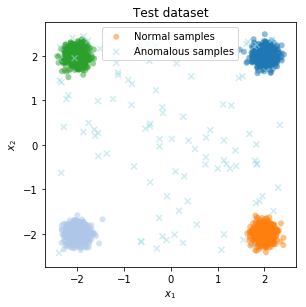

In [17]:
plt.clf()
fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/15.0),
           edgecolor='none', alpha=0.5, label="Normal samples")

ax.scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/15),
       edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')

ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Test dataset")
ax.legend()
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()

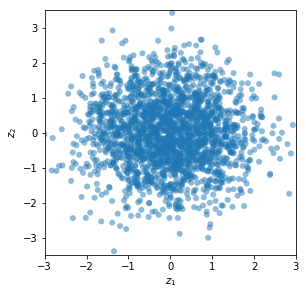

In [18]:
# create Z dataset

datasetZ_test = sample_GMM(X_np_data_test.shape[0], means_z, variances_z, priors_z, sources=('features', ))
save_path = result_dir + 'Z_gmm_data_test.png'
# plot_GMM(dataset, save_path)

Z_np_data_test = datasetZ_test.data['samples']
Z_targets_test = datasetZ_test.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_np_data_test[:, 0], Z_np_data_test[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(save_path, transparent=True, bbox_inches='tight')
plt.show()

In [19]:
### Testing

In [20]:
x = torch.Tensor(X_np_data_test) 
z = torch.Tensor(Z_np_data_test)

imx = gen(z).data.cpu().numpy()
imz = inf(x).data.cpu().numpy()
rmz = inf( gen(z) ).data.cpu().numpy()
rmx = gen( inf(x) ).data.cpu().numpy()


mahalanobis_dis_z = torch.norm(inf(x), p=2, dim=1)

score_dz = mahalanobis_dis_z

score = score_dz #+ score_dxx
score = np.linalg.norm(imz, ord=2, axis=1, keepdims = False)
print(score)

def zmar(imz):
    return np.linalg.norm(imz, ord=2, axis=1, keepdims=False)

[0.94582504 0.96950173 1.3552006  ... 0.82206935 0.1679091  0.02540582]


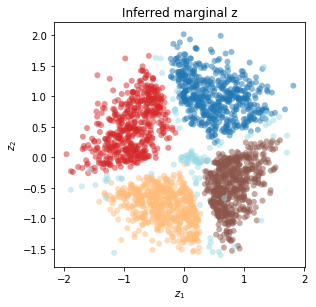

In [21]:
## inferred marginal z
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ll = X_targets_test
ax.scatter(imz[:, 0], imz[:, 1], c=cm.tab20(ll.astype(float)/input_dim/3.0),
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title("Inferred marginal z")
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

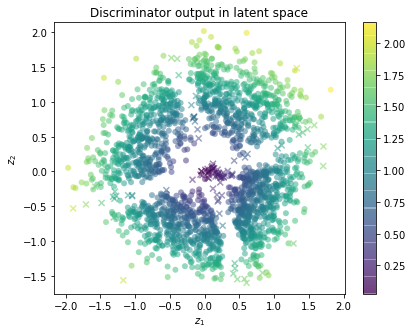

In [22]:
import matplotlib as mpl

## discriminator z choice on latent - v3
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 5))

colors = score#zmar(score)
norm = mpl.colors.Normalize(vmin=min(colors), vmax=max(colors))

im = ax.scatter(imz[idx_inliers, 0], imz[idx_inliers, 1], c=colors[idx_inliers],
        edgecolor='none', alpha=0.5, label="Normal samples", marker='o', norm=norm)

im = ax.scatter(imz[idx_outliers, 0], imz[idx_outliers, 1], c=colors[idx_outliers],
        edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x', norm=norm)

#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
fig_mz.colorbar(im)
ax.axis('on')
plt.axis('equal')
ax.set_title("Discriminator output in latent space")
plt.savefig(result_dir + 'inferred_{}_mz_disc.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

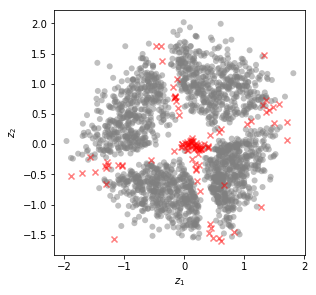

In [23]:
## discriminator z choice on latent - v2
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(imz[idx_inliers][:, 0], imz[idx_inliers][:, 1], c='grey',
        edgecolor='none', alpha=0.5)
ax.scatter(imz[idx_outliers][:, 0], imz[idx_outliers][:, 1], c='r',
        edgecolor='none', alpha=0.5, marker='x')
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

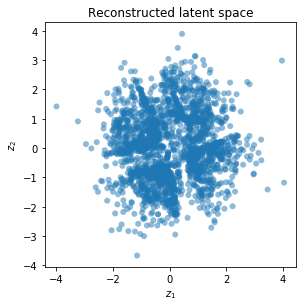

In [24]:


##  reconstructed z
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(rmz[:, 0], rmz[:, 1],
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title('Reconstructed latent space')
plt.savefig(result_dir + 'reconstruct_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()



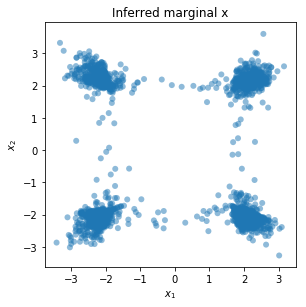

In [25]:
## inferred marginal x
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(imx[:, 0], imx[:, 1],
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Inferred marginal x")
plt.savefig(result_dir + 'inferred_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

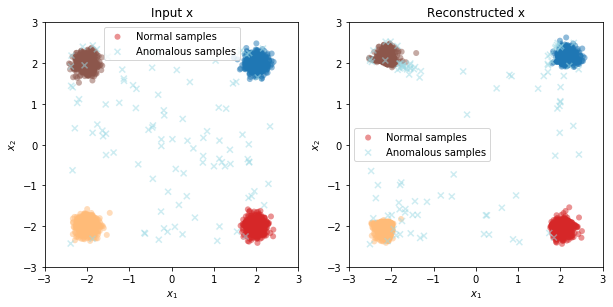

In [26]:
##  reconstructed x
fig_mx, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))
ax[0].scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[0].scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[0].set_xlabel('$x_1$'); ax[0].set_ylabel('$x_2$')
ax[0].axis('on')
ax[0].set_xlim(-3, 3); ax[0].set_ylim(-3, 3)
ax[0].legend()
ax[0].set_title("Input x")

ax[1].scatter(rmx[idx_inliers, 0], rmx[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[1].scatter(rmx[idx_outliers, 0], rmx[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[1].set_xlim(-3, 3); ax[1].set_ylim(-3, 3)
ax[1].set_xlabel('$x_1$'); ax[1].set_ylabel('$x_2$')
ax[1].axis('on')
ax[1].legend()
ax[1].set_title("Reconstructed x")
plt.savefig(result_dir + 'reconstruct_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

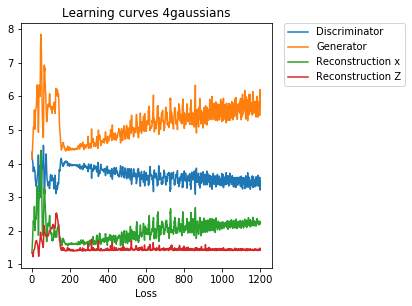

In [27]:

## learning curves
fig_curve, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.plot(FD, label="Discriminator")
ax.plot(np.array(FG)[:,0], label="Generator")
ax.plot(np.array(FG)[:,1], label="Reconstruction x")
ax.plot(np.array(FG)[:,2], label="Reconstruction Z")
plt.xlabel('Iteration')
plt.xlabel('Loss')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('on')
ax.set_title("Learning curves {}".format(DATASET))
plt.savefig(result_dir + 'learning_curves_{}.png'.format(DATASET), bbox_inches='tight')
plt.show()
